# Code Part

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_ecg = pd.read_csv("../datasetsCSV/mit_arrhythmia/ECGs.csv")
rpeaks = pd.read_csv("../datasetsCSV/mit_arrhythmia/Rpeaks.csv")


In [3]:
data_ecg.head()

ECG        Participant  Sample  Sampling_Rate        Database
0 -0.145  MIT-Arrhythmia_00       0            360  MIT-Arrhythmia
1 -0.145  MIT-Arrhythmia_00       1            360  MIT-Arrhythmia
2 -0.145  MIT-Arrhythmia_00       2            360  MIT-Arrhythmia
3 -0.145  MIT-Arrhythmia_00       3            360  MIT-Arrhythmia
4 -0.145  MIT-Arrhythmia_00       4            360  MIT-Arrhythmia

In [4]:
rpeaks

Rpeaks        Participant  Sampling_Rate          Database
0           77  MIT-Arrhythmia_00            360    MIT-Arrhythmia
1          370  MIT-Arrhythmia_00            360    MIT-Arrhythmia
2          662  MIT-Arrhythmia_00            360    MIT-Arrhythmia
3          946  MIT-Arrhythmia_00            360    MIT-Arrhythmia
4         1231  MIT-Arrhythmia_00            360    MIT-Arrhythmia
...        ...                ...            ...               ...
125591  214879  MIT-Arrhythmia_47            360  MIT-Arrhythmia-x
125592  215113  MIT-Arrhythmia_47            360  MIT-Arrhythmia-x
125593  215346  MIT-Arrhythmia_47            360  MIT-Arrhythmia-x
125594  215592  MIT-Arrhythmia_47            360  MIT-Arrhythmia-x
125595  215827  MIT-Arrhythmia_47            360  MIT-Arrhythmia-x

[125596 rows x 4 columns]

In [5]:
ecgpaciente=data_ecg[data_ecg.Participant=='MIT-Arrhythmia_00']

## R peak new

In [6]:
import scipy.signal as sig


In [62]:
class Rashik2016():
    def chebyshevI_bandpass(self,input):
        # Parameters
        order = 4
        fs = 360  # Sample rate in Hz (adjust as needed)
        low = 6    # Lower cutoff frequency in Hz
        high = 18  # Upper cutoff frequency in Hz
        
        # Chebyshev Type I Bandpass filter
        Apass = 1  # Passband Ripple (dB)
        nyquist = 0.5 * fs
        low = low / nyquist
        high = high / nyquist
        
        b, a = sig.cheby1(order, Apass, [low, high], btype='bandpass')
        
        custom_filter =sig.TransferFunction(b, a)
        return sig.lfilter(b, a, input)

    def join_r_peaks(self,signal, fs, peak_locs_temp, thresh):
        # Join the peaks that are too close
        i = 1
        while i < len(peak_locs_temp):
            if abs(peak_locs_temp[i] - peak_locs_temp[i - 1]) < thresh:
                if signal[peak_locs_temp[i]] >= signal[peak_locs_temp[i - 1]]:
                    peak_locs_temp.pop(i - 1)
                else:
                    peak_locs_temp.pop(i)
            else:
                i += 1
    
        return peak_locs_temp
    def join_r_peaks_loop(self,signal, fs, peak_locs_temp, thresh):
        min_peak_locs_len = len(signal)
        peak_locs_final = self.join_r_peaks(signal, fs, peak_locs_temp, thresh)
    
        while len(peak_locs_final) < min_peak_locs_len:
            min_peak_locs_len = len(peak_locs_final)
            peak_locs_final = self.join_r_peaks(signal, fs, peak_locs_final, thresh)
    
        return peak_locs_final
    def real_r_peak_detection(self,signal, fs, peak_locs_temp, thresh):
        peak_locs_final = []
        
        for i in range(len(peak_locs_temp)):
            l_bound = round(peak_locs_temp[i] - thresh)
            r_bound = round(peak_locs_temp[i] + thresh)
    
            # Ensure the bounds stay within valid indices
            l_bound = max(l_bound, 0)
            r_bound = min(r_bound, len(signal) - 1)
    
            peak_value = max(signal[l_bound:r_bound + 1])
            max_peak_locs = [index + l_bound for index, value in enumerate(signal[l_bound:r_bound + 1]) if value == peak_value]
    
            if len(max_peak_locs) > 1:
                if max_peak_locs[0] not in peak_locs_final:
                    peak_locs_final.append(max_peak_locs[0])
            else:
                if max_peak_locs[0] not in peak_locs_final:
                    peak_locs_final.append(max_peak_locs[0])
    
        # Check if the final peak list is within the threshold sample range and join the peaks
        peak_locs_final = self.join_r_peaks_loop(signal, fs, peak_locs_final, thresh)
    
        return peak_locs_final

    def real_r_peak_detection_loop(self,signal, fs, peak_locs_temp, thresh):
        peak_locs_final = self.real_r_peak_detection(signal, fs, peak_locs_temp, thresh)
        last_peak_locs = []
    
        while peak_locs_final != last_peak_locs:
            last_peak_locs = peak_locs_final
            peak_locs_final = self.real_r_peak_detection(signal, fs, peak_locs_final, thresh)
    
        return peak_locs_final
    def solve(self,signal):
        '''
        Solver, Combines all the above functions
        :param signal: input signal
        :return: prcoessed signal
    
        First the signal is filtered using a band pass filter, then passed in a differentiator
        followed by square wave generator, and then into a moving window integrator. The final signal is
        returned to to the caller.
        '''
    
        band_pass_signal = self.chebyshevI_bandpass(signal.copy())
        band_pass_signal_r= np.flipud(band_pass_signal)
        band_pass_signal_r = self.chebyshevI_bandpass(band_pass_signal_r.copy())
        CHv= np.flipud(band_pass_signal_r)
        
        # First order differentiation
        f_signal=CHv
        d_n = f_signal[1:] - f_signal[:-1]

        # Normalize the signal
        norm_dn = np.abs(d_n) / np.max(np.abs(d_n))
        norm=norm_dn 
        # Shannon energy envelope
        se_n = (-1) * (norm_dn**2) * np.log(norm_dn**2)
        
        # Moving average filter
        N = 65
        ma_filter = np.ones(N) / N
       # s_n = sig.lfilter(ma_filter, 1, se_n)
        s_n = sig.convolve(se_n, ma_filter, mode='valid')
        # Calculate the number of zeros to pad at the beginning and end
        pad_length = len(f_signal) - len(s_n)
        pad_left = pad_length // 2
        pad_right = pad_length - pad_left
        
        # Zero-pad the filtered signal to match the input signal length
        s_n_padded = np.pad(s_n, (pad_left, pad_right), mode='constant')
        s_n=s_n_padded
        # First order differentiation
        d_n_2 = s_n[1:] - s_n[:-1]
        
        # Normalize the signal
        norm_sig_2 = np.abs(d_n_2) / np.max(np.abs(d_n_2))
        
        # Squaring
        s_n_2 = norm_sig_2**2
        
        # Moving average filter
        N = 85
        ma_filter = np.ones(N) / N
       # out_sig = sig.lfilter(ma_filter, 1, s_n_2)
        out_sig  = sig.convolve(s_n_2, ma_filter, mode='valid')
        pad_length = len(f_signal) - len(out_sig )
        pad_left = pad_length // 2
        pad_right = pad_length - pad_left
        
        # Zero-pad the filtered signal to match the input signal length
        out_sig_padded = np.pad(out_sig , (pad_left, pad_right), mode='constant')
       
        # Find peaks in the signal
        peak_locs_temp, _ = sig.find_peaks(out_sig_padded,distance=150)
        peak_locs_final = self.real_r_peak_detection_loop(f_signal,fs,peak_locs_temp,25);
        return      out_sig_padded,s_n_padded ,s_n,norm,CHv, out_sig,peak_locs_temp,peak_locs_final
        #derivative_signal = self.derivative(band_pass_signal.copy())
        #square_signal = self.squaring(derivative_signal.copy())
        #moving_window_avg_signal = self.moving_window_integration(square_signal.copy())
    
        #return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal
    

QRS_detectorTest = Rashik2016()


ecg_signal = ecgpaciente.ECG.values

fs =360
out_sig_padded,s_n_padded ,s_n,norm,CHv, out_sig,peak_locs_temp,devolvio=QRS_detectorTest.solve(ecg_signal.copy())
#integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detectorTest.solve(ecg_signal.copy())
    

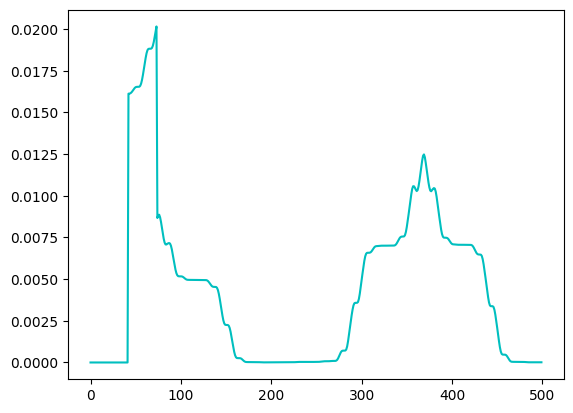

In [63]:
plt.plot(out_sig_padded[:500], 'c-', label="sn")


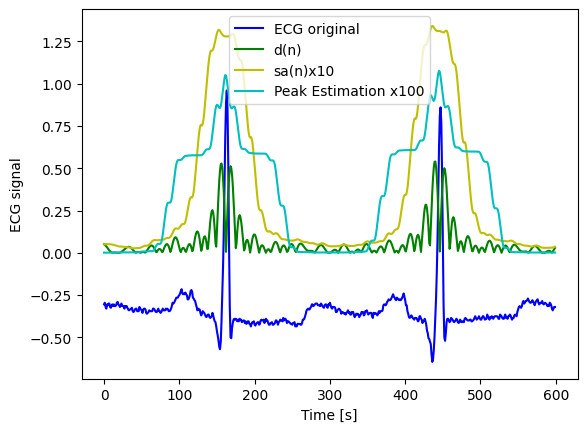

In [64]:
plt.plot(ecg_signal[500:1100],'b-', label="ECG original")
plt.plot(norm[500:1100], 'g-', label="d(n)")
plt.plot(s_n_padded[500:1100]*10, 'y-', label="sa(n)x10")
plt.plot(out_sig_padded[500:1100]*100, 'c-', label="Peak Estimation x100")

#plt.plot(out_sig[500:1100], 'm-', label="Final")
plt.ylabel('ECG signal')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [65]:
devolvio[:10]


[77, 370, 662, 946, 1231, 1515, 1809, 2044, 2227, 2402]

In [66]:
peak_locs_temp[:10]

array([  73,  369,  661,  945, 1230, 1513, 1808, 2043, 2202, 2401])

## QRS Detection


In [13]:
class Pan_Tompkins_QRS():

  def low_pass_filter(self, signal):
    '''
    Low Pass Filter
    :param signal: input signal
    :return: processed signal

    '''
    low_pass_signal = signal.copy()
    for time in time_stamp:
      curr = signal[time] 

      if (time >= 1):
        curr += 2*low_pass_signal[time-1]

      if (time >= 2):
        curr -= low_pass_signal[time-2]

      if (time >= 6):
        curr -= 2*signal[time-6]
      
      if (time >= 12):
        curr += signal[time-12]

      low_pass_signal[time] = curr
    low_pass_signal = low_pass_signal/ max(abs(low_pass_signal))
    return low_pass_signal

  def high_pass_filter(self, signal):
    '''
    High Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    '''

    high_pass_signal = signal.copy()

    for time in time_stamp:
      curr = -1*signal[time]

      if (time >= 16):
        curr += 32*signal[time-16]

      if (time >= 1):
        curr -= high_pass_signal[time-1]

      if (time >= 32):
        curr += signal[time-32]

      high_pass_signal[time] = curr 
    high_pass_signal = high_pass_signal/max(abs(high_pass_signal))
    return high_pass_signal

  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    A bandpass filter is created by a combination of a high pass filter and a low pass filter. 
    The signal is first filtered with a low pass filter and the output of the low pass filter
    is given to a high pass filter. The function of the filter is to eliminate
    noise due to muscle contractions, T-waves, or any other noise present in the data. The implementation 
    is on the lines with Pan Tompkin's research paper 
    '''
    low_pass_signal = self.low_pass_filter(signal)
    band_pass_signal = self.high_pass_filter(low_pass_signal)

    return band_pass_signal    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    The implementation is as given in the research paper. It is used 
    to get the slope information for the QRS complex. It takes the 
    filtered signal as an input. 
    '''
    T = 1/fs
    derivative_signal = signal.copy()

    for time in time_stamp:
      curr = 0

      if (time >= 2):
        curr -= signal[time-2]

      if (time >= 1):
        curr -= 2*signal[time-1]
        
      if (time < len(time_stamp)-1):
        curr += 2*signal[time+1]

      if (time < len(time_stamp)-2):
        curr += signal[time+2]
      derivative_signal[time] = (curr/(8*T))
    
    return derivative_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    This just squares all the values in the waveform. It provides a non-linear amplification
    to the higher frequency components of QRS complexes in the derivative signal. 
    '''
    return np.square(signal)

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    It is a kind of running average within a window of certain size. Here I took a window 
    of 0.15 seconds. This basically serves as a tool for detection and finding features
    of QRS complexes and R peaks.
    '''
    WINDOW_SIZE = 0.15*fs
    moving_window_signal = signal.copy()
    for time in time_stamp:
      index = 0
      curr = 0
      while (index < WINDOW_SIZE):
        if (time < index):
          break
        curr += signal[time-index]
        index += 1

      moving_window_signal[time] = curr/index
    return moving_window_signal


  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    First the signal is filtered using a band pass filter, then passed in a differentiator
    followed by square wave generator, and then into a moving window integrator. The final signal is
    returned to to the caller.
    '''

    band_pass_signal = self.band_pass_filter(signal.copy())
    derivative_signal = self.derivative(band_pass_signal.copy())
    square_signal = self.squaring(derivative_signal.copy())
    moving_window_avg_signal = self.moving_window_integration(square_signal.copy())

    return moving_window_avg_signal,band_pass_signal, derivative_signal, square_signal


QRS_detector = Pan_Tompkins_QRS()

ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])

ecg_signal = ecg.iloc[:,1].to_numpy()
time_stamp = ecg.TimeStamp

fs = annotation.fs
integration_signal, band_pass_signal, derivative_signal, square_signal  = QRS_detector.solve(ecg_signal.copy())
    

## Plotting the Signals
consider using matlplotlib(or other plotting libraries) to create images for report. Please write code below \\


Text(0.5, 1.0, 'Moving window averaged ECG Signal')

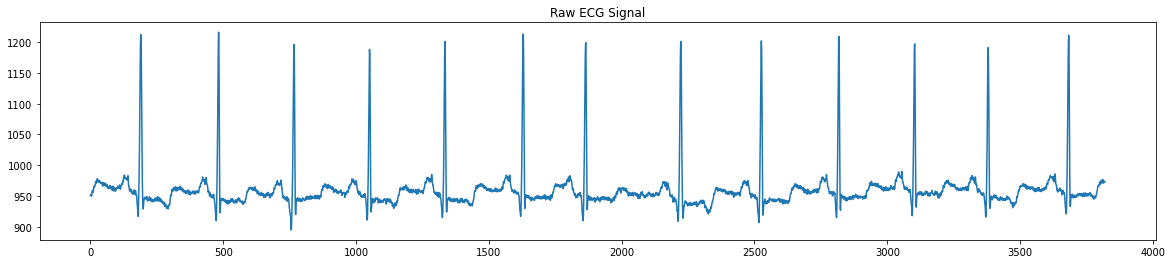

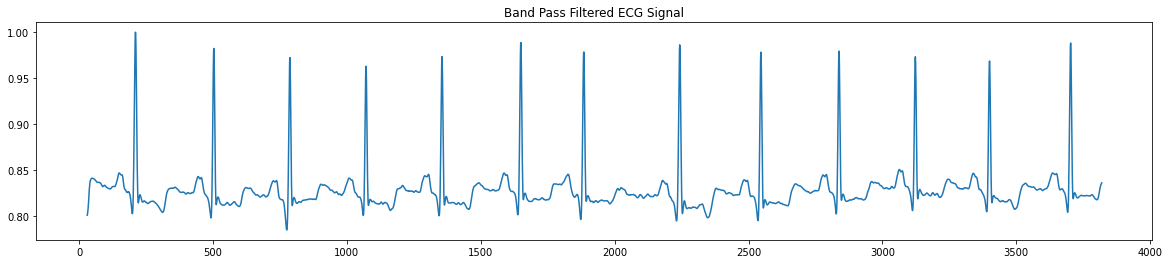

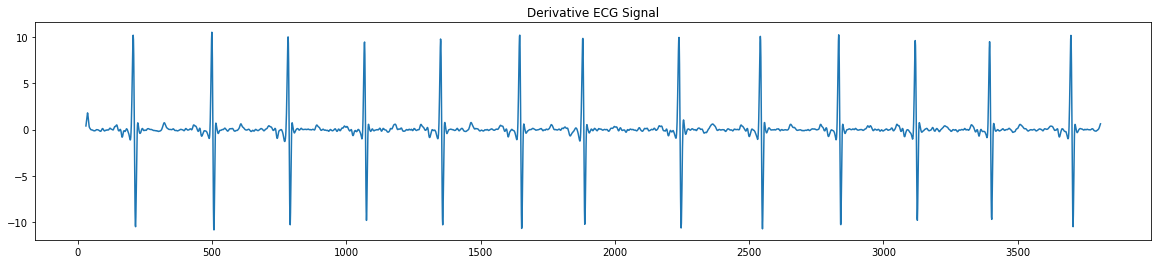

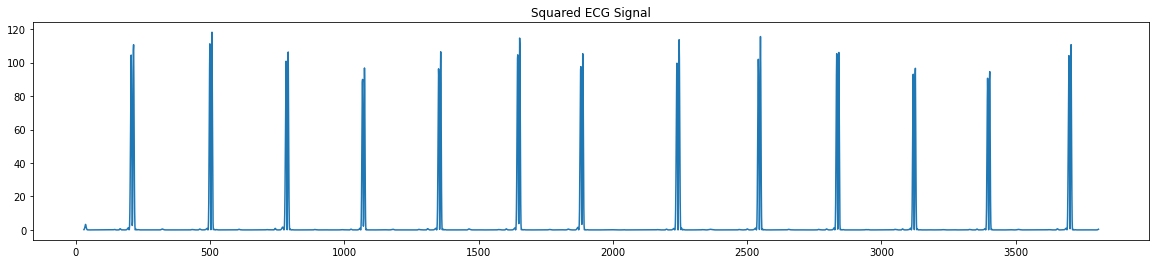

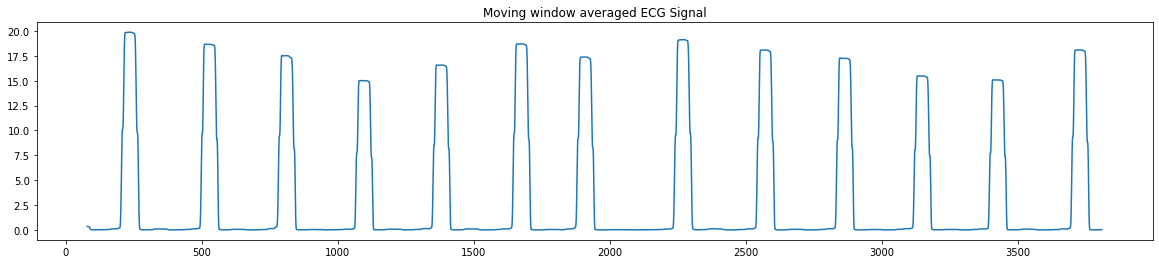

In [14]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)
plt.title("Raw ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:], band_pass_signal[30:])
plt.title("Band Pass Filtered ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], derivative_signal[30:len(time_stamp)-10])
plt.title("Derivative ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[30:len(time_stamp)-10], square_signal[30:len(time_stamp)-10]) 
plt.title("Squared ECG Signal")

plt.figure(figsize=(20,4))
plt.plot(time_stamp[80:len(time_stamp)-10], integration_signal[80:len(time_stamp)-10]) 
plt.title("Moving window averaged ECG Signal")


## Calculating Heart Rate
In this section you need to write code to calculate heart rate of the given ecg signal using the help of QRS detected. \\
(1mark)

In [15]:
def detect_peaks(ecg_signal, fs): 
    # Initialization of variables

    possible_peaks = []
    signal_peaks = []
    r_peaks = []
    # running estimate of the signal peak
    SPKI = 0
    # running estimate of the signal peak
    SPKF = 0
    # running estimate of the noise peak
    NPKI = 0
    # running estimate of the noise peak
    NPKF = 0
    rr_avg_one = []
    # First Integrated result threshold
    THRESHOLDI1 = 0
    # First Filtered result threshold
    THRESHOLDF1 = 0
    rr_avg_two = []
    # Second Integrated result threshold
    THRESHOLDI2 = 0
    # Second Filtered result threshold
    THRESHOLDF2 = 0
    # T wave detection flag
    is_T_found = 0
    # A search window of samples corresponding to 0.15 seconds
    window = round(0.15 * fs)            

    # Stage I: Fudicial Mark possible_peaks on the integrated signal
    FM_peaks = []
    # Smoothening the integration signal
    integration_signal_smooth = np.convolve(integration_signal, np.ones((20,)) / 20, mode = 'same')    
    localDiff = np.diff(integration_signal_smooth)
    # finding local maxima using difference array and ignoring
    # possible_peaks before initialization step i.e before fs

    for i in range(1,len(localDiff)):
        if i-1 > 2*fs and localDiff[i-1] > 0 and localDiff[i] < 0 :
            FM_peaks.append(i-1)           

    # Find out the possbile peaks for all the local maximas
    for index in range(len(FM_peaks)):

        # Finding maximum value position in the current search window
        current_peak = FM_peaks[index]
        left_limit = max(current_peak-window, 0) 
        right_limit = min(current_peak+window+1, len(band_pass_signal))
        max_index = -1
        max_value = -sys.maxsize
        for i in range(left_limit, right_limit):
            if(band_pass_signal[i] > max_value):
                max_value = band_pass_signal[i]
                max_index = i
        if (max_index != -1):
            possible_peaks.append(max_index)

        if (index == 0 or index > len(possible_peaks)):
          # if first peak
          if (integration_signal[current_peak] >= THRESHOLDI1): 
              SPKI = 0.125 * integration_signal[current_peak]  + 0.875 * SPKI
              if possible_peaks[index] > THRESHOLDF1:                                            
                  SPKF = 0.125 * band_pass_signal[index] + 0.875 * SPKF 
                  signal_peaks.append(possible_peaks[index])                             
              else:
                  NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF                                    
              
          elif ( (integration_signal[current_peak] > THRESHOLDI2 and integration_signal[current_peak] < THRESHOLDI1) or (integration_signal[current_peak] < THRESHOLDI2)):
              NPKI = 0.125 * integration_signal[current_peak]  + 0.875 * NPKI  
              NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF

        else:
            RRAVERAGE1 = np.diff(FM_peaks[max(0,index-8):index + 1]) / fs
            rr_one_mean = np.mean(RRAVERAGE1)
            rr_avg_one.append(rr_one_mean) 
            limit_factor = rr_one_mean
              
            if (index >= 8):
                # calculate RR limits and rr_avg_two
                for RR in RRAVERAGE1:
                    if RR > RR_LOW_LIMIT and RR < RR_HIGH_LIMIT:                              
                        rr_avg_two.append(RR)
                        if (len(rr_avg_two) == 9):
                          rr_avg_two.pop(0)     
                          limit_factor = np.mean(rr_avg_two)
            # set the RR limits
            if (len(rr_avg_two) == 8 or index < 8):
                RR_LOW_LIMIT = 0.92 * limit_factor        
                RR_HIGH_LIMIT = 1.16 * limit_factor
                RR_MISSED_LIMIT = 1.66 * limit_factor

            # Decrease the thresholds to half, if irregular beats detected
            if rr_avg_one[-1] < RR_LOW_LIMIT or rr_avg_one[-1] > RR_MISSED_LIMIT: 
                THRESHOLDI1 = THRESHOLDI1/2
                THRESHOLDF1 = THRESHOLDF1/2
               
            # If current RR interval is greater than RR_MISSED_LIMIT perform search back
            curr_rr_interval = RRAVERAGE1[-1]
            search_back_window = round(curr_rr_interval * fs)
            if curr_rr_interval > RR_MISSED_LIMIT:
                left_limit = current_peak - search_back_window +1
                right_limit = current_peak + 1
                search_back_max_index = -1 
                max_value =  -sys.maxsize
                # local maximum in the search back interval
                for i in range(left_limit, right_limit):
                  if (integration_signal[i] > THRESHOLDI1 and integration_signal[i] > max_value ):
                    max_value = integration_signal[i]
                    search_back_max_index = i
              
                if (search_back_max_index != -1):   
                    SPKI = 0.25 * integration_signal[search_back_max_index] + 0.75 * SPKI                         
                    THRESHOLDI1 = NPKI + 0.25 * (SPKI - NPKI)
                    THRESHOLDI2 = 0.5 * THRESHOLDI1               
                    # finding peak using search back of 0.15 seconds
                    left_limit = search_back_max_index - round(0.15 * fs)
                    right_limit = min(len(band_pass_signal), search_back_max_index)

                    search_back_max_index2 = -1 
                    max_value =  -sys.maxsize
                    # local maximum in the search back interval
                    for i in range(left_limit, right_limit):
                      if (band_pass_signal[i] > THRESHOLDF1 and band_pass_signal[i] > max_value ):
                        max_value = band_pass_signal[i]
                        search_back_max_index2 = i

                    # QRS complex detected
                    if band_pass_signal[search_back_max_index2] > THRESHOLDF2: 
                        SPKF = 0.25 * band_pass_signal[search_back_max_index2] + 0.75 * SPKF                            
                        THRESHOLDF1 = NPKF + 0.25 * (SPKF - NPKF)
                        THRESHOLDF2 = 0.5 * THRESHOLDF1                            
                        signal_peaks.append(search_back_max_index2)                                                 
    
            # T-wave detection
            if (integration_signal[current_peak] >= THRESHOLDI1): 
                if (curr_rr_interval > 0.20 and curr_rr_interval < 0.36 and index > 0): 
                    # slope of current waveformm which is most probabaly a T-wave, using mean width of QRS complex 0.075
                    current_slope = max(np.diff(integration_signal[current_peak - round(fs * 0.075):current_peak + 1]))
                    # slope of the preceding waveform, which is mosty probabaly QRS complex
                    previous_slope = max(np.diff(integration_signal[FM_peaks[index - 1] - round(fs * 0.075): FM_peaks[index - 1] + 1]))
                    if (current_slope < 0.5 * previous_slope): 
                        NPKI = 0.125 * integration_signal[current_peak] + 0.875 * NPKI                                            
                        is_T_found = 1                              
                #  This is a signal peak
                if (not is_T_found):
                    SPKI = 0.125 * integration_signal[current_peak]  + 0.875 * SPKI
                    # check if it is present in the possible peaks otherwise it is a noise peak
                    if possible_peaks[index] > THRESHOLDF1:                                            
                        SPKF = 0.125 * band_pass_signal[index] + 0.875 * SPKF 
                        signal_peaks.append(possible_peaks[index])                             
                    else:
                        NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF                   
                                        
            elif ((integration_signal[current_peak] > THRESHOLDI1 and integration_signal[current_peak] < THRESHOLDI2) or (integration_signal[current_peak] < THRESHOLDI1)):
                NPKI = 0.125 * integration_signal[current_peak]  + 0.875 * NPKI  
                NPKF = 0.125 * band_pass_signal[index] + 0.875 * NPKF
       
        THRESHOLDI1 = NPKI + 0.25 * (SPKI - NPKI)
        THRESHOLDF1 = NPKF + 0.25 * (SPKF - NPKF)
        THRESHOLDI2 = 0.5 * THRESHOLDI1 
        THRESHOLDF2 = 0.5 * THRESHOLDF1
        is_T_found = 0  

    # searching in ECG signal to increase accuracy
    for i in np.unique(signal_peaks):
        i = int(i)
        window = round(0.2 * fs)
        left_limit = i-window
        right_limit = min(i+window+1, len(ecg_signal))
        max_value = -sys.maxsize
        max_index = -1
        for i in range(left_limit, right_limit):
            if (ecg_signal[i] > max_value):
                max_value = ecg_signal[i]
                max_index = i

        r_peaks.append(max_index)
        
    return r_peaks
                    
r_peaks = detect_peaks(ecg_signal, fs)
heart_beat = np.average(np.diff(r_peaks))/ fs
print("Heart Rate: "+ str(60/heart_beat) + " BPM")

Heart Rate: 74.07407407407408 BPM


**Note:** The peak detection takes a learning window of 2 seconds to initialize variables properly. Thus peaks in that time window are not detected by the algorithm.

**Plotting R peaks**

Text(0.5, 1.0, 'Raw ECG Signal with Detected Peaks')

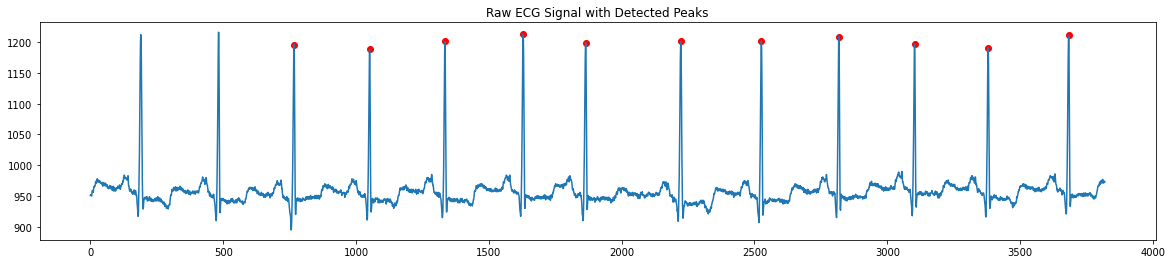

In [16]:
plt.figure(figsize=(20,4))
plt.plot(time_stamp, ecg_signal)        
plt.scatter(r_peaks, ecg_signal[r_peaks], c = 'r')
plt.title("Raw ECG Signal with Detected Peaks")


# Report

## Your Understanding of the Algorithm


The Pan-Tompkins algorithm can be broken down in the following steps: (The summary of first 5 steps is already given above)

# Signal Processing:

*   **Bandpass filtering**
*   **Derivative**
*   **Squaring**
*   **Moving window integration**

# R-Peak Detection and calculation of heart-rates

*   **Fudicial Mark:**  A fudicial mark of the locations(wrt time) of all the possbile QRS complexes is created. The QRS complexes are marked by rising edges in the integrated waveform. To create the fudicial mark we use the differentiated signal, and try to see the slope change from postive to negative. We further keep track of moving window thresholds to filter out peaks which are not of QRS complex (not R peaks)

*   **Maintaining sinal and noise thresholds:** The thresholds are maintained for both the noise and the signal peaks. The calculation of the next step of each threshold depends on the previouly found peaks. Thresholds are able to adapt quickly to rapidly changing heart rates by keeping running estimates of both signal and noise levels from previous peak assignments. They help in peak detection also. The criteria and the formulas are given in the pan tompkins paper. 
*   **RR intervals and their limits:** Two heartbeats are needed to establish the average RR interval and rate limits. If any of the eight most recent sequential beats fall outside the the  accepted low and high RR-interval limits, heart rate is considered to be irregular and the signal and noise thresholds are reduced by half in order to increase sensitivity.
*   **Searchback:** During normal sinus rhythm, if a QRS complex is not identified within 166 percent of the average of the previous eight beats, it is assumed that a QRS complex has been missed. A searchback procedure is then initiated, with the goal of identifying the greatest peak within the current signal and noise thresholds as a candidate for a QRS complex. There are certain criterias requried for the peak to qualify as an R peak.

*   **T-wave Identification:** Once a QRS complex has been discovered, there is a 200-ms refractory period during which another beat is physically impossible, allowing for the eradication of any QRS detection within this time frame. If a QRS is discovered after the refractory period but before 360 ms after the preceding QRS, we must determine whether this peak is a true QRS complex or a T-wave. A T-wave is diagnosed when the slope of its peak is less than half of the slope of the previous QRS.

Following all the steps, we are able to detect QRS complexes and thus R-peaks and heart rates using RR intervals.


## Results


Note: The order of image display for each record is in reverse order. So for any record 10X, start looking from the bottom of it to the top.


**Record 100**

Heart Rate: 74.074 BPM

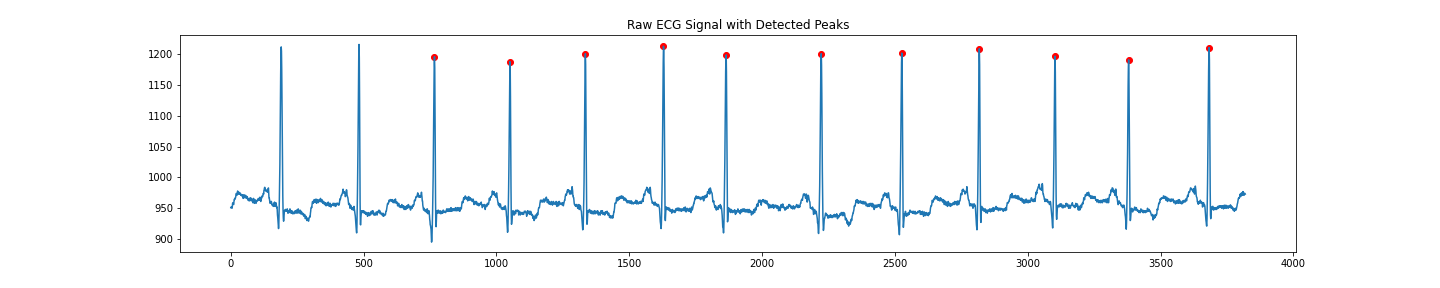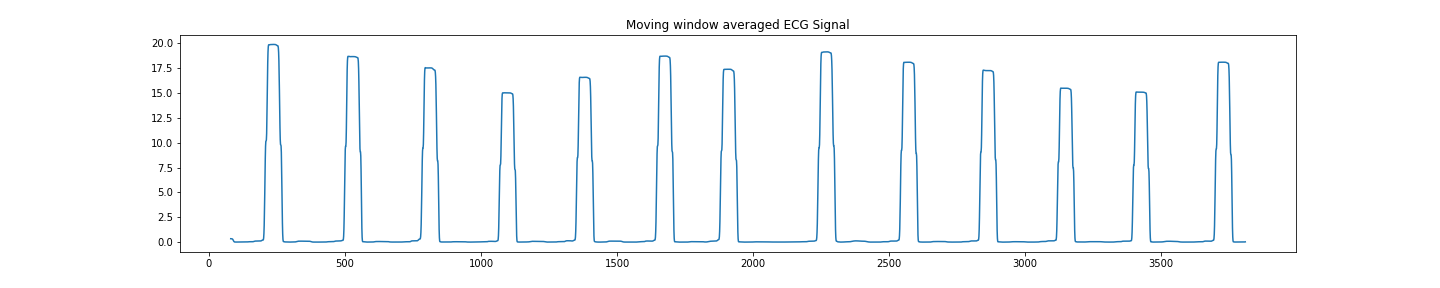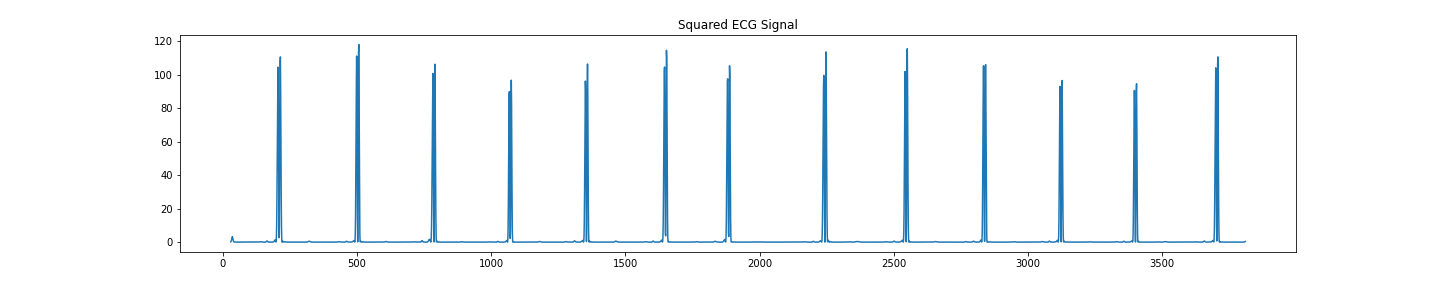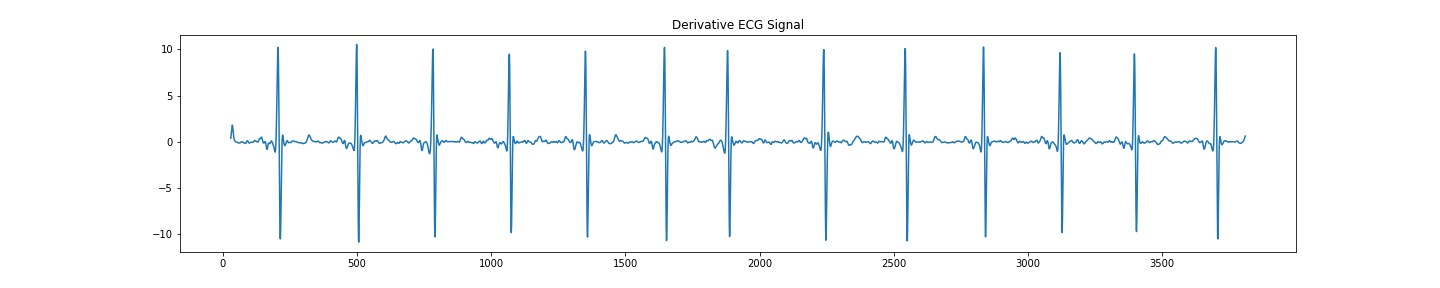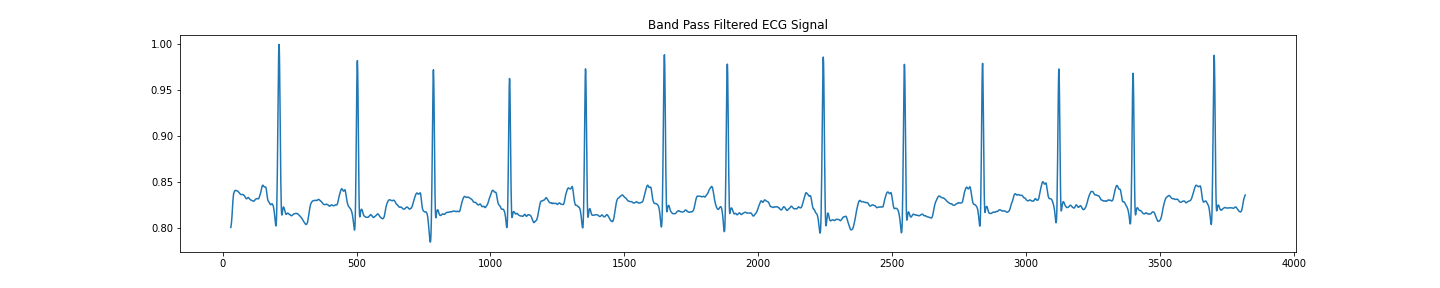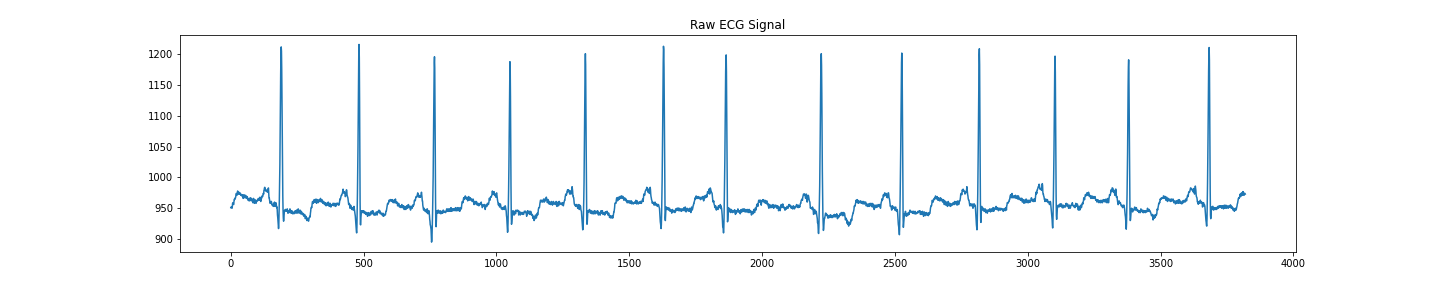

**Record 101**

Heart Rate: 73.770 BPM

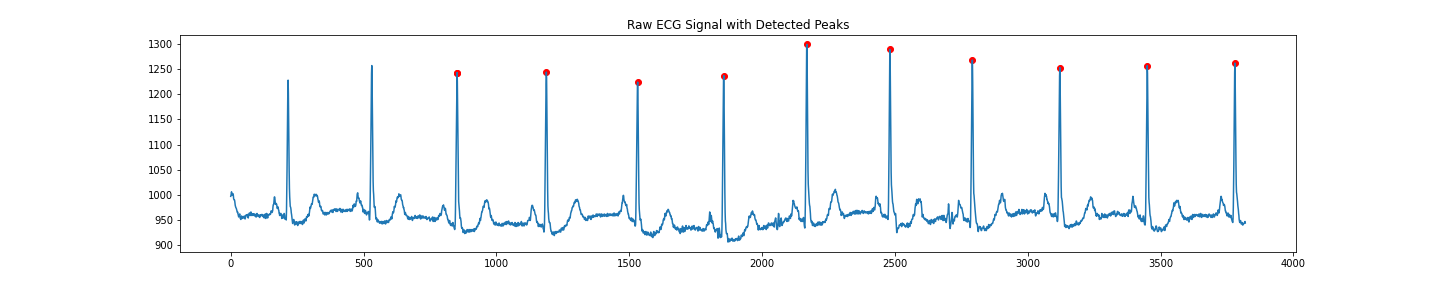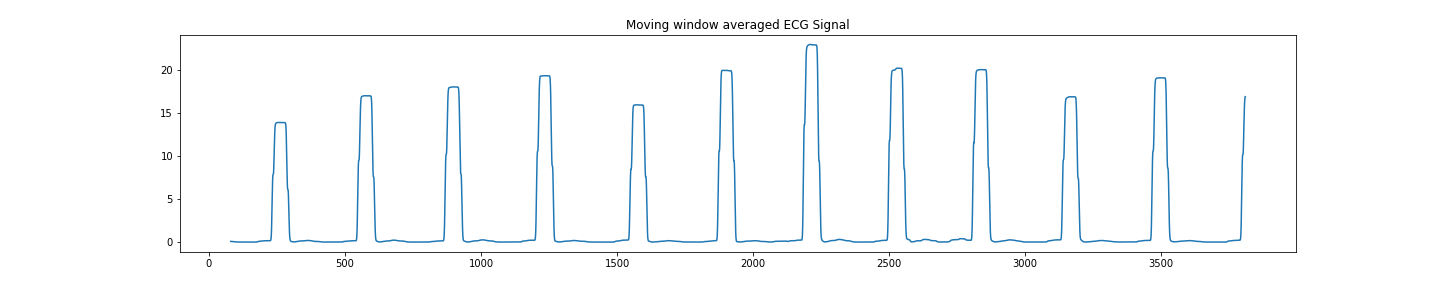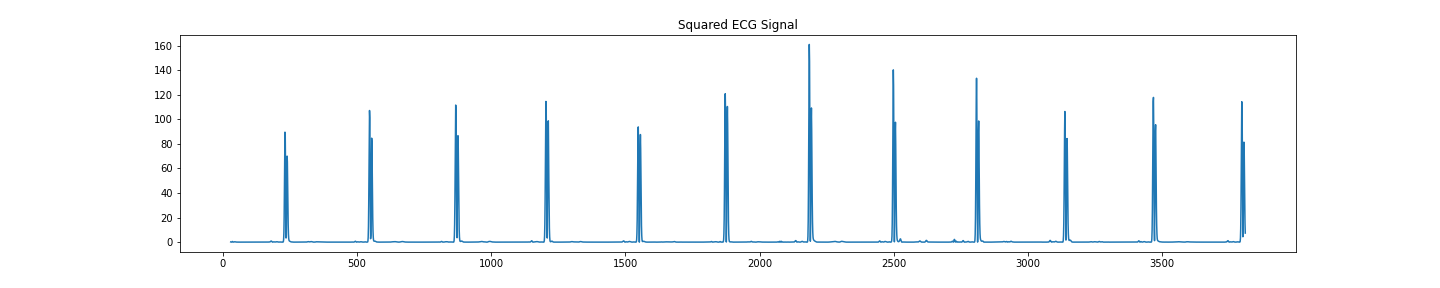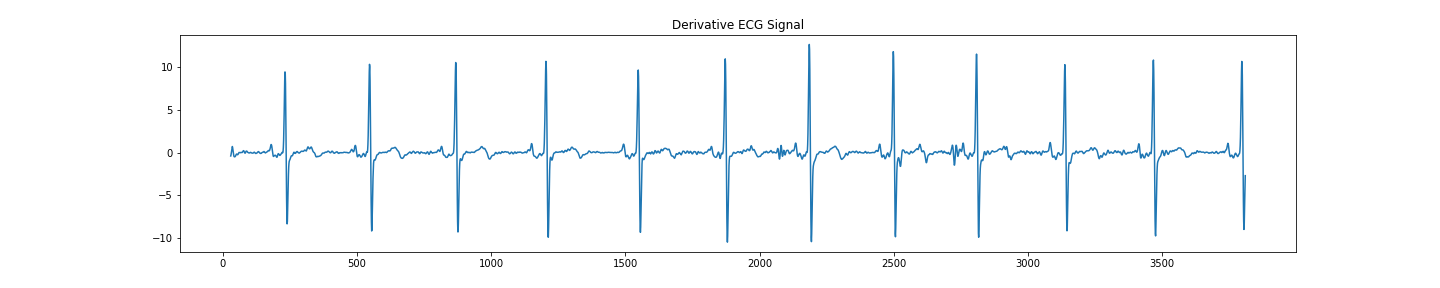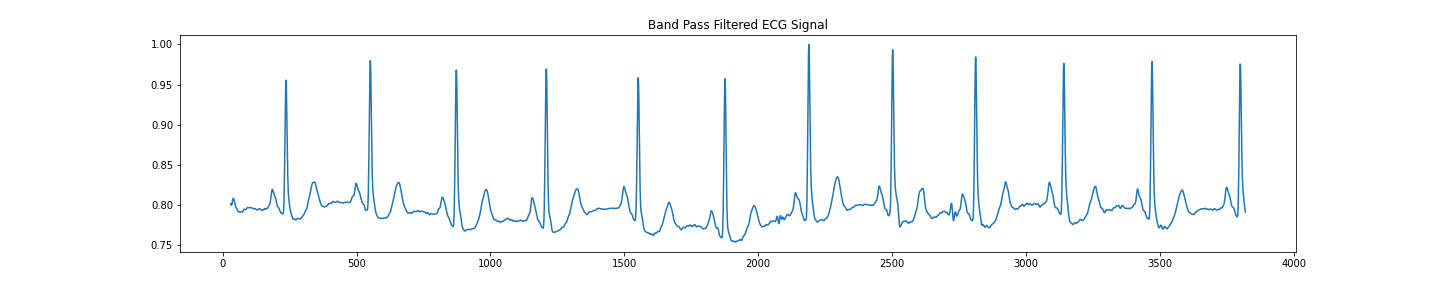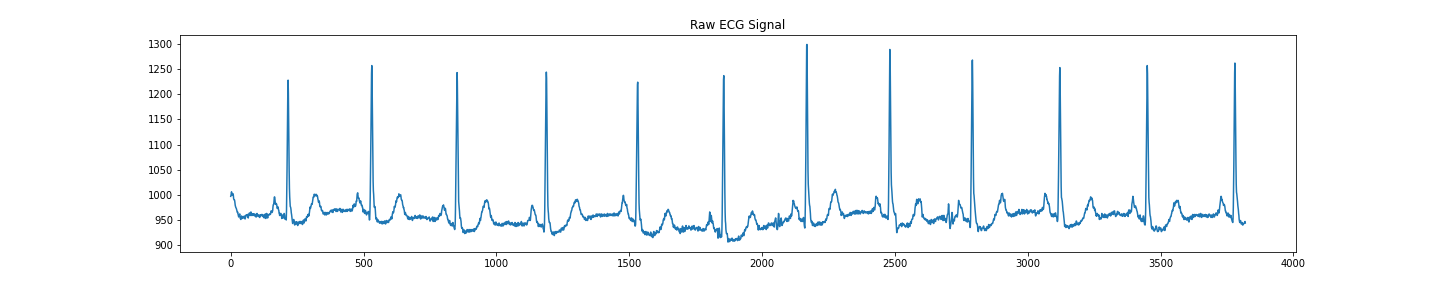

**Record 102**

Heart Rate: 71.92 BPM

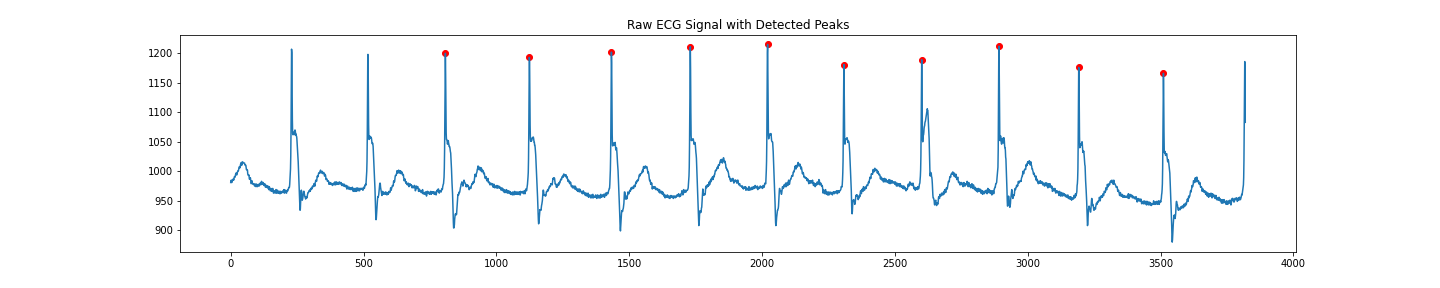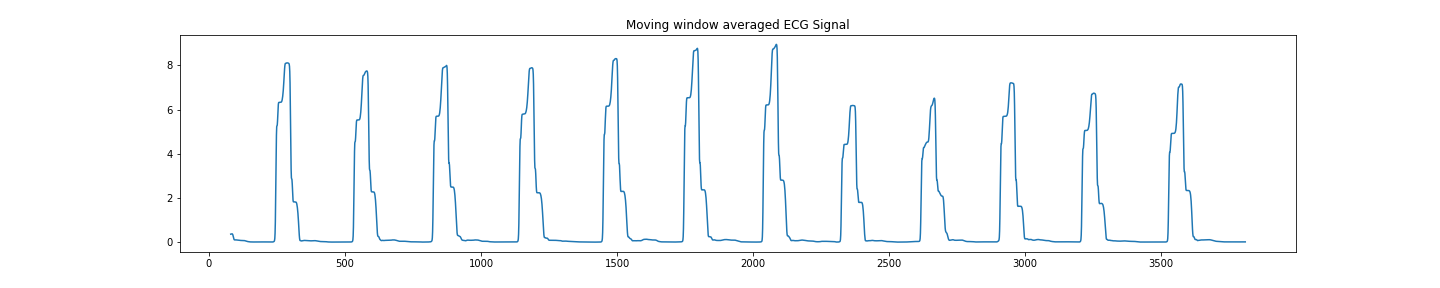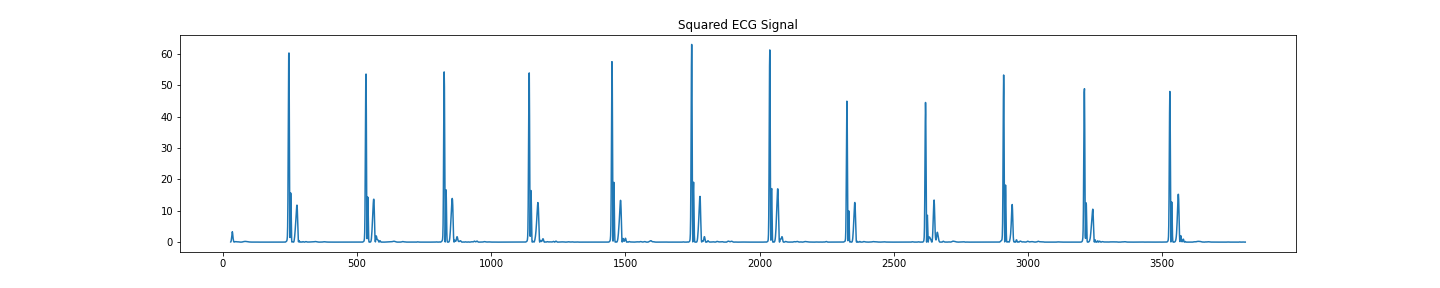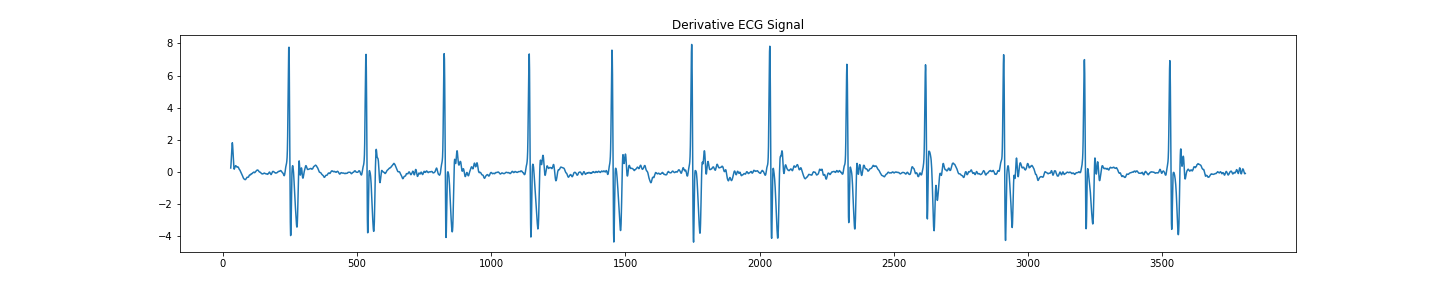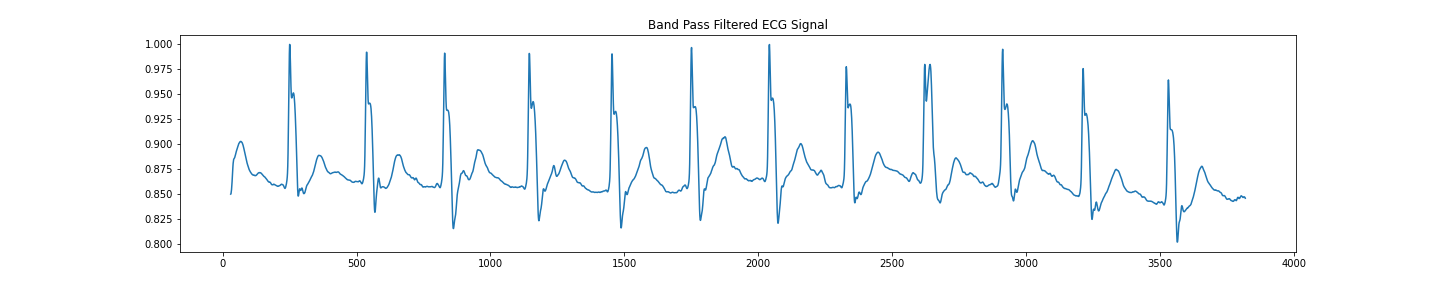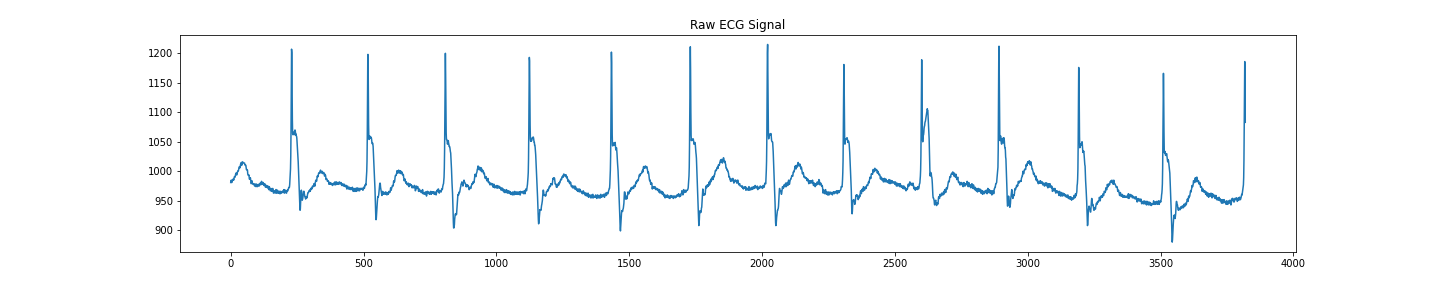

**Record 103**

Heart Rate: 70.175 BPM

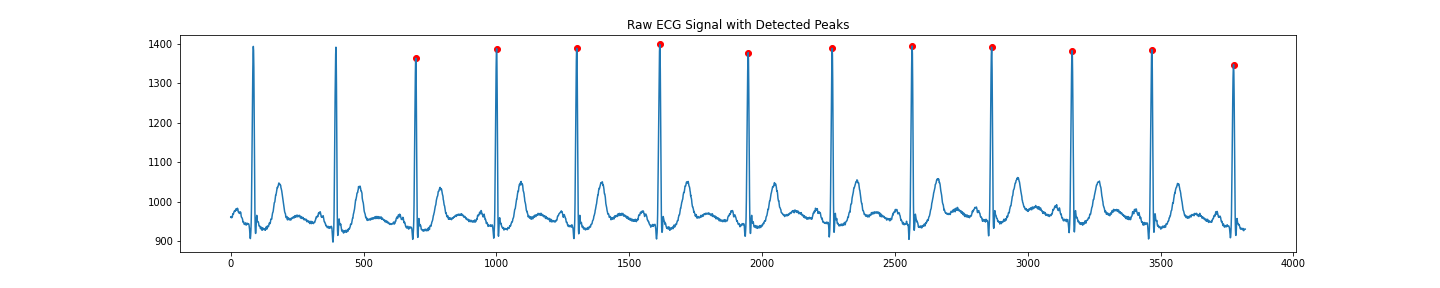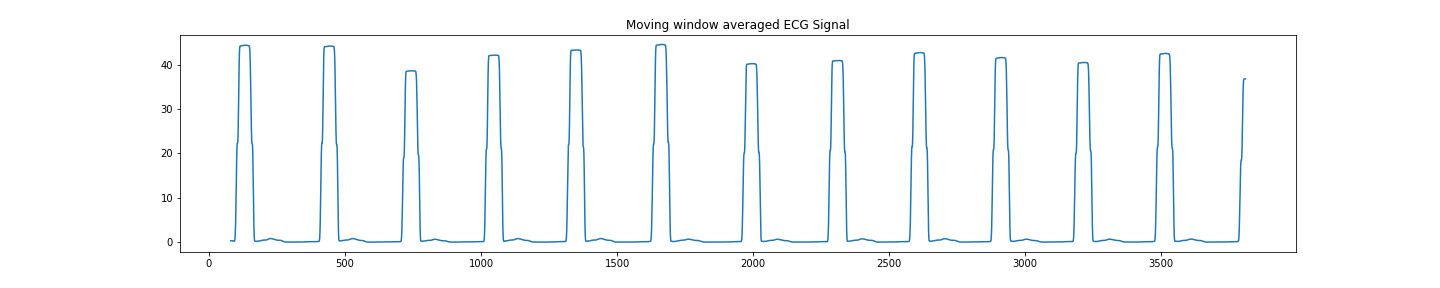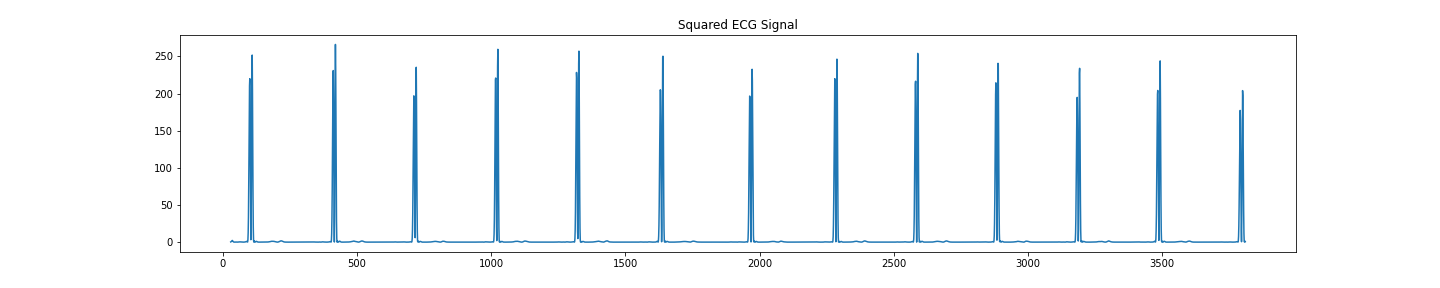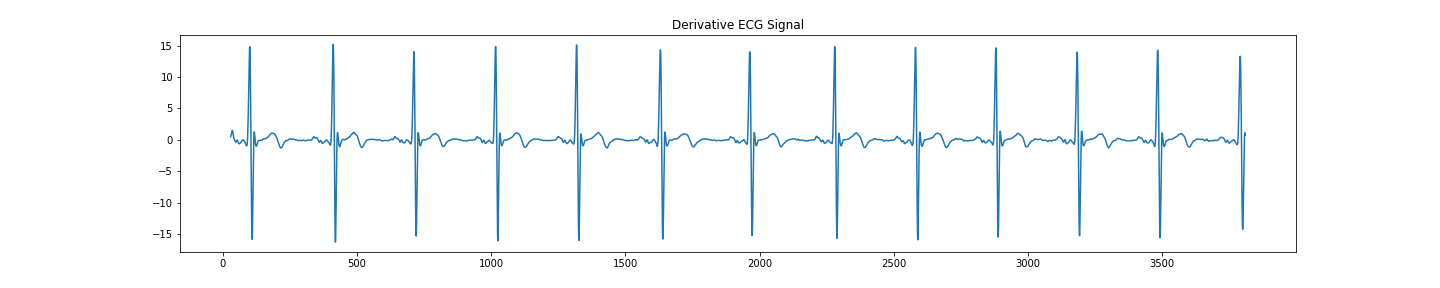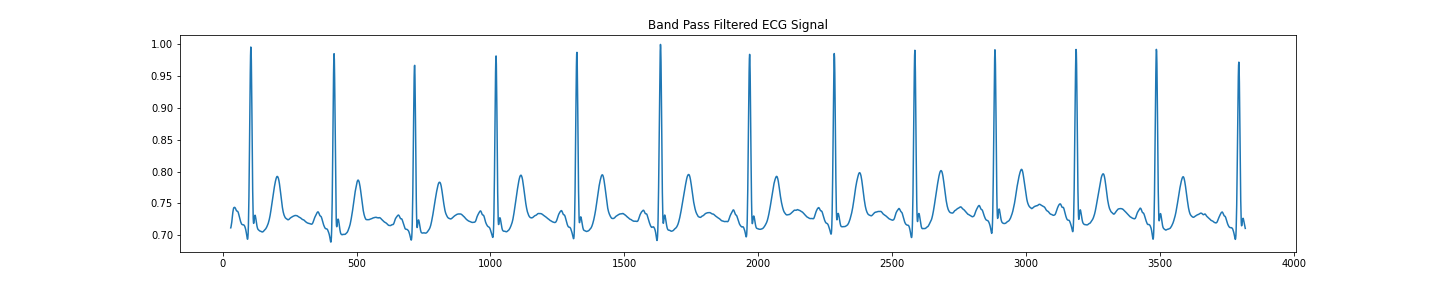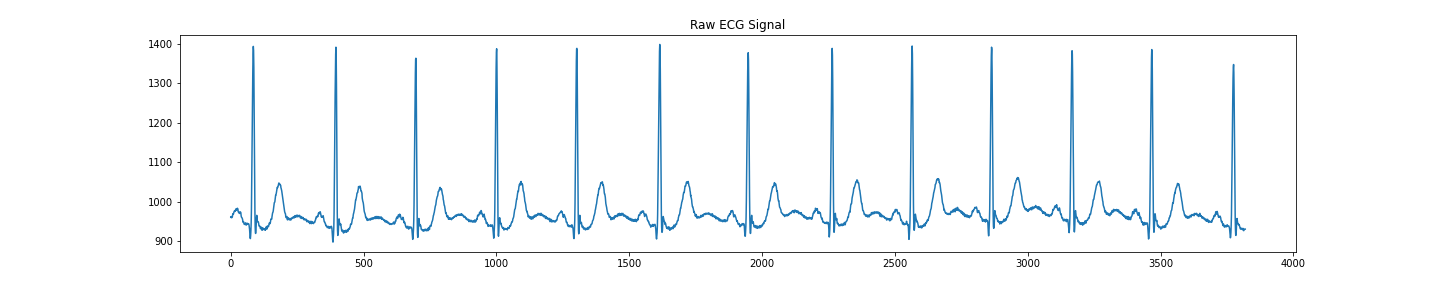

**Record 104**

Heart Rate: 74.586 BPM

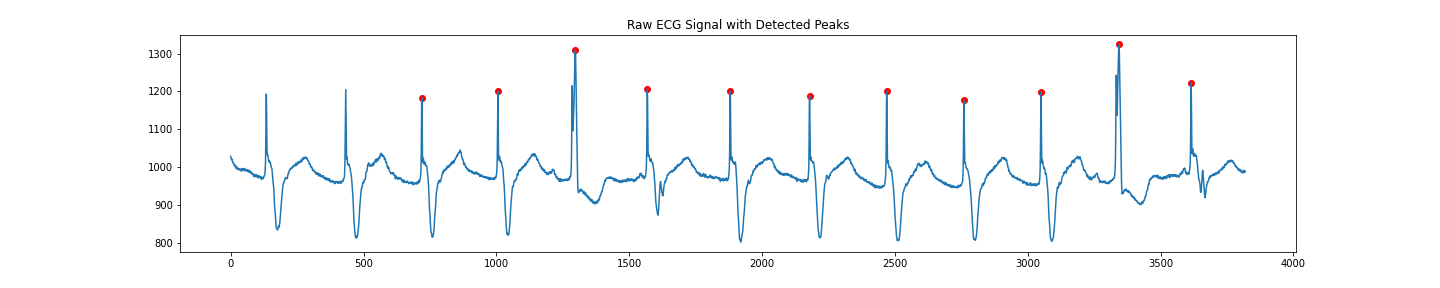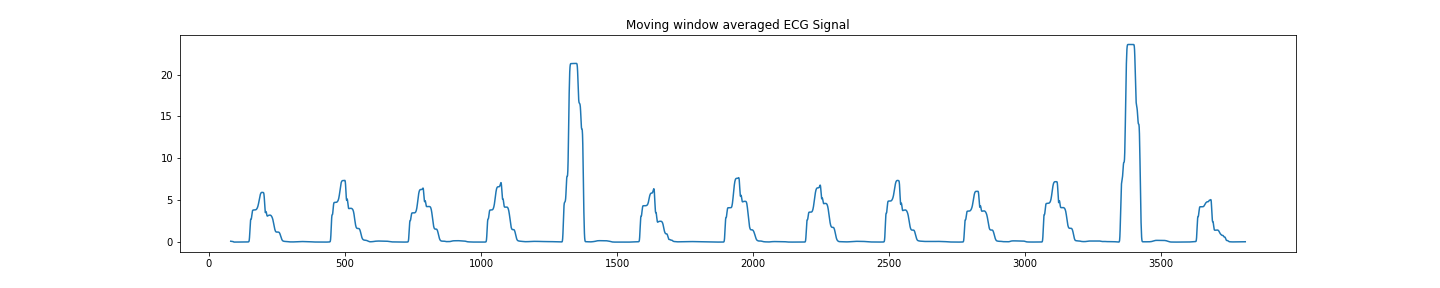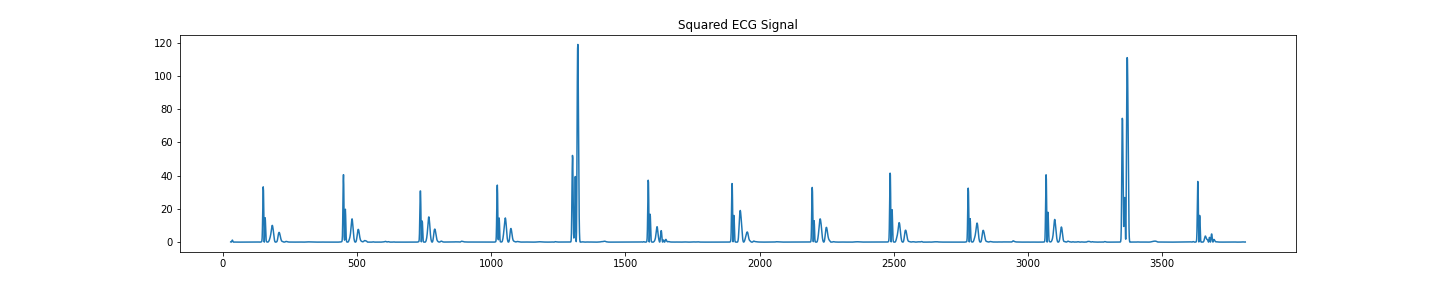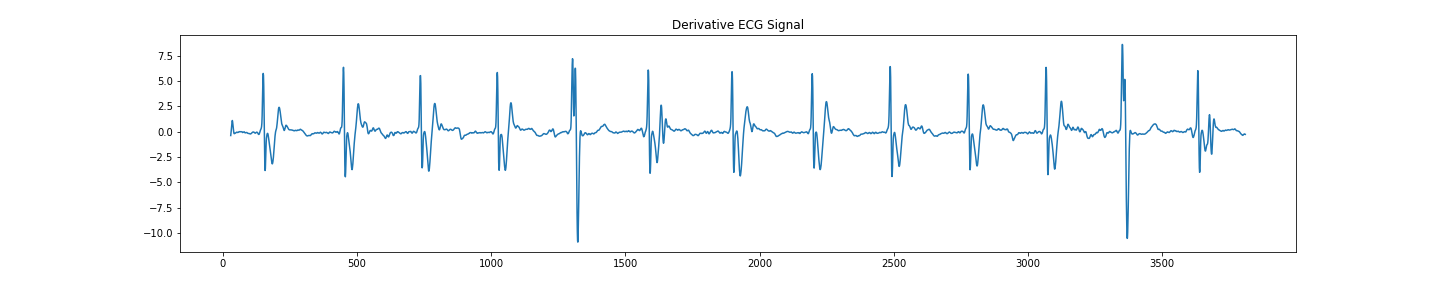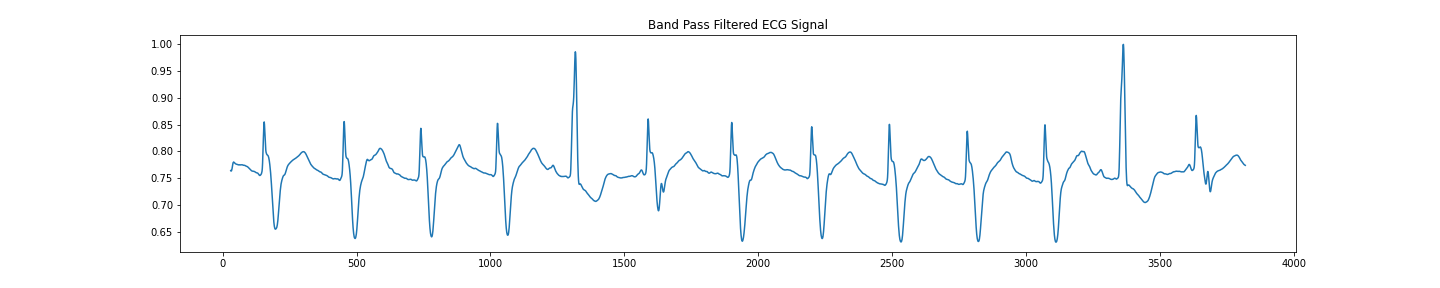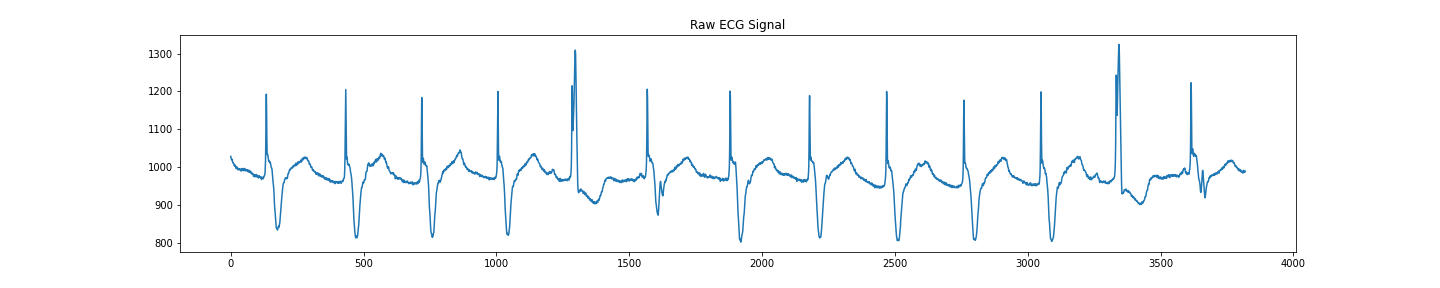

**Record 105**

Heart Rate: 82.759 BPM

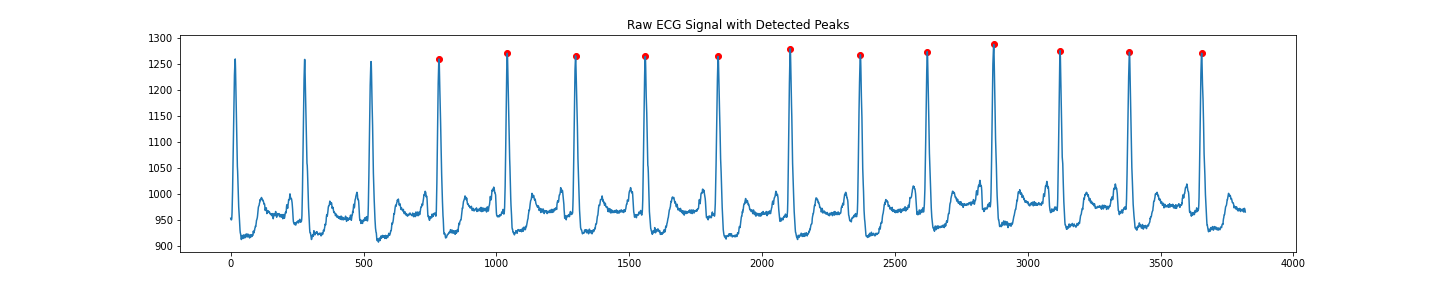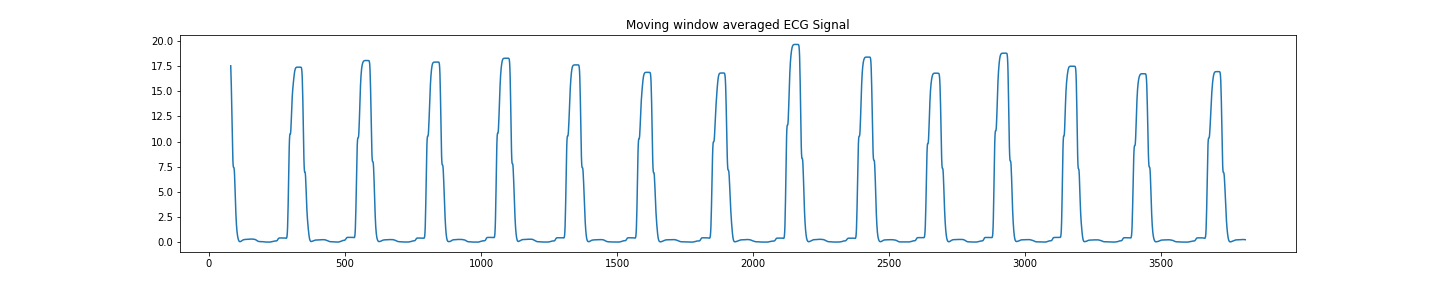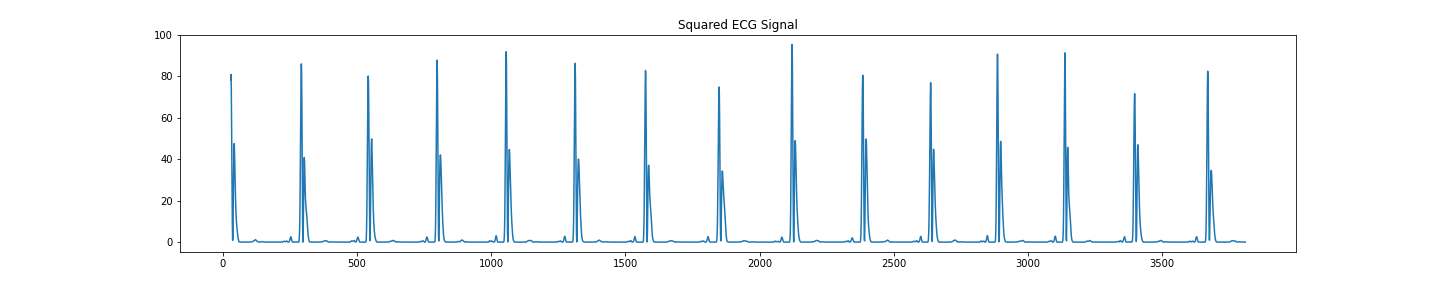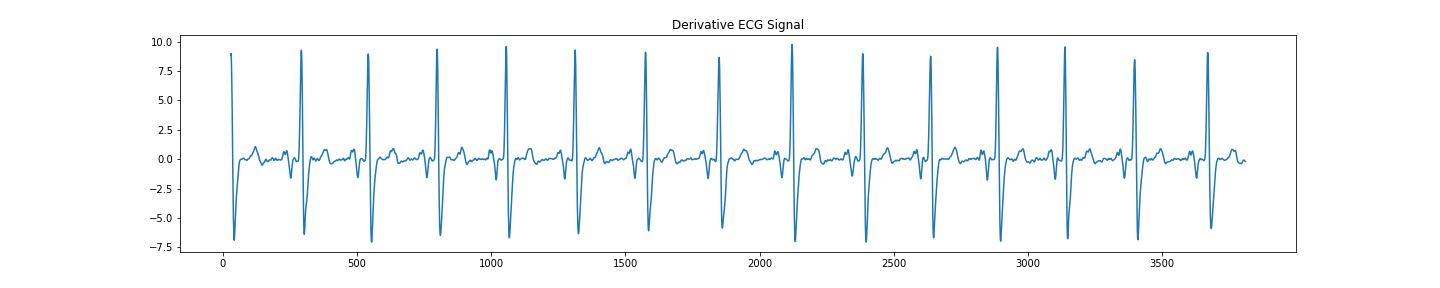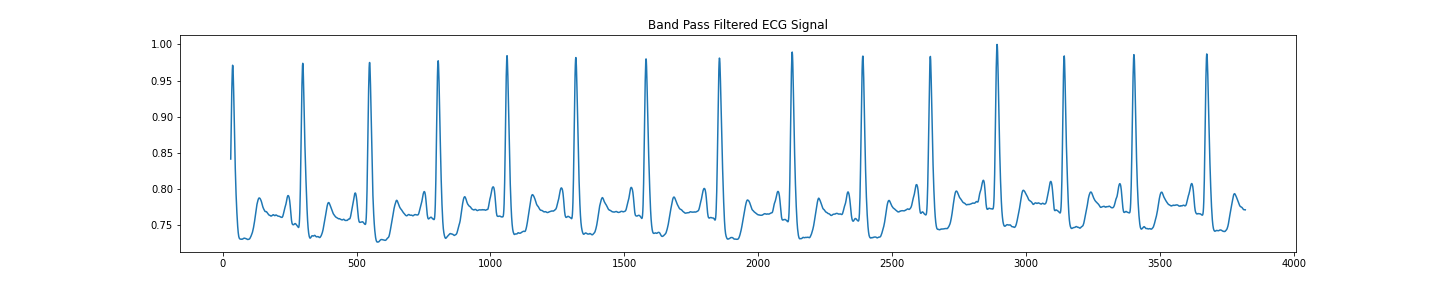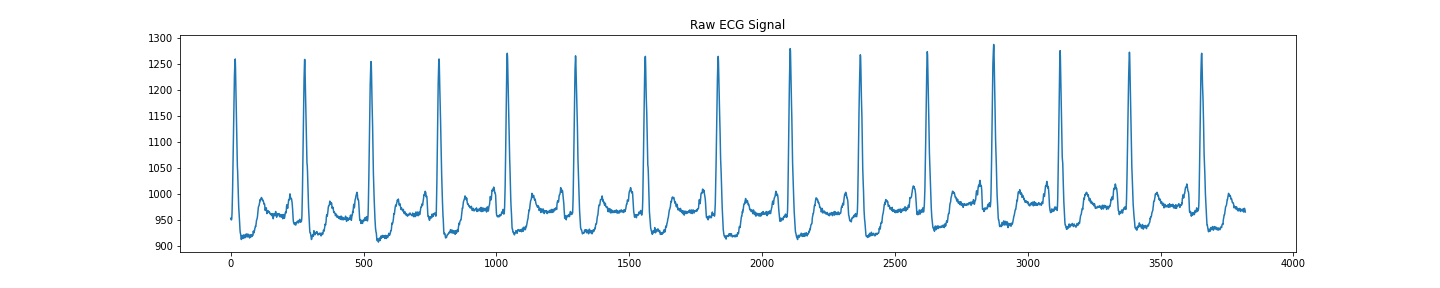

**Record 106**

Heart Rate: 64.286 BPM

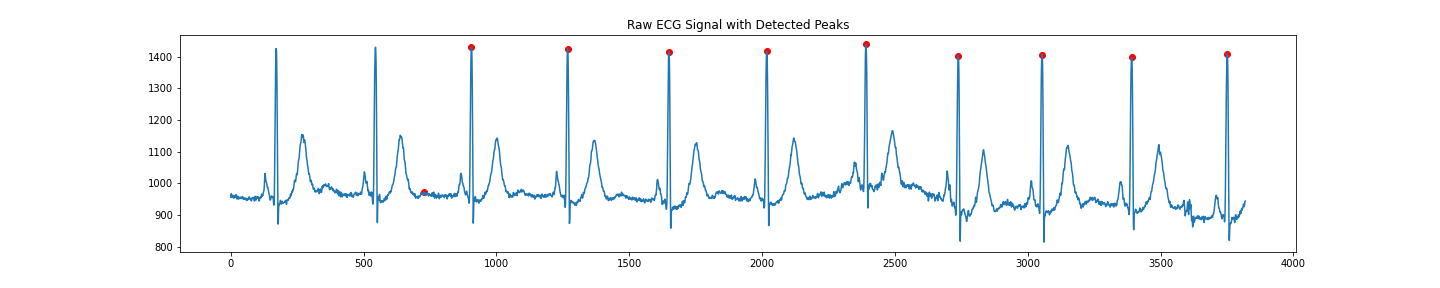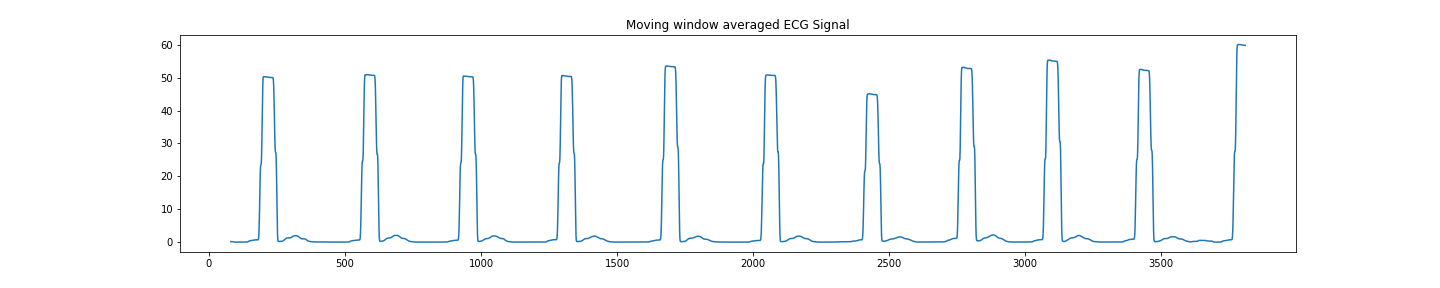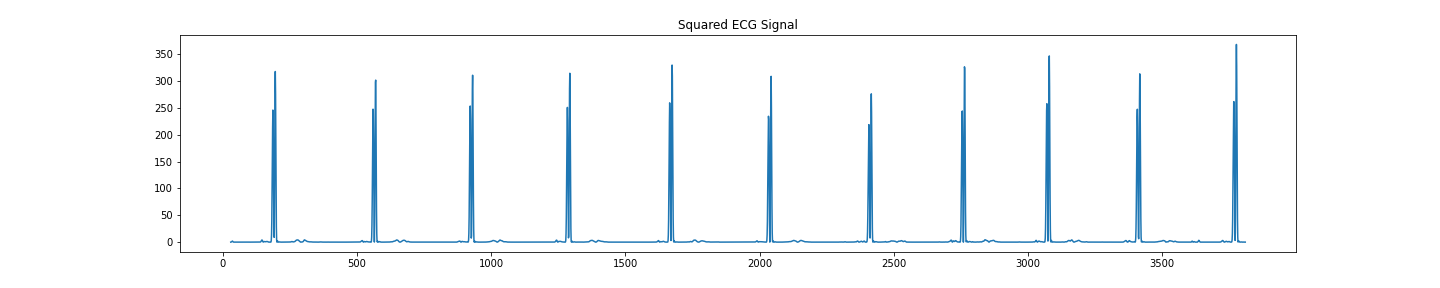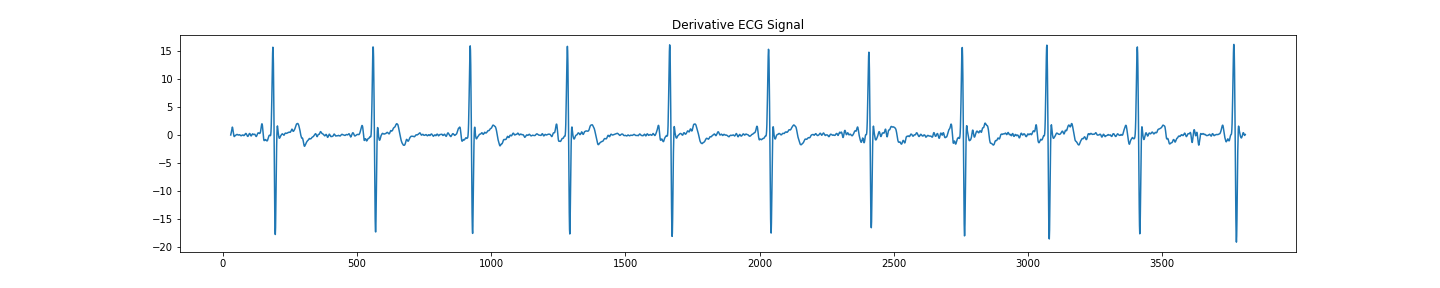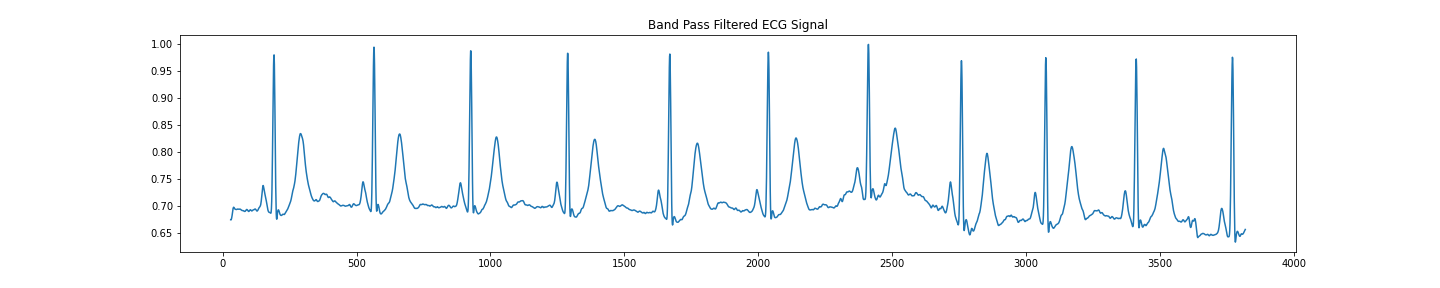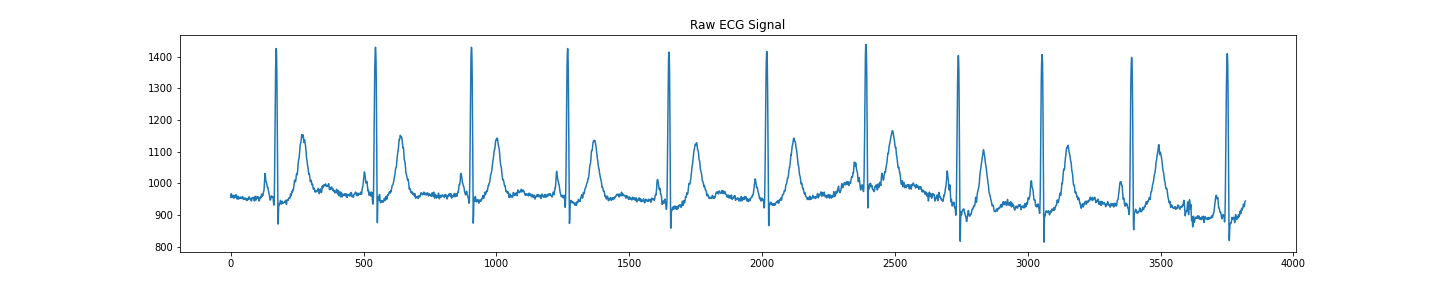



**Record 107**

Heart Rate: 76.968 BPM

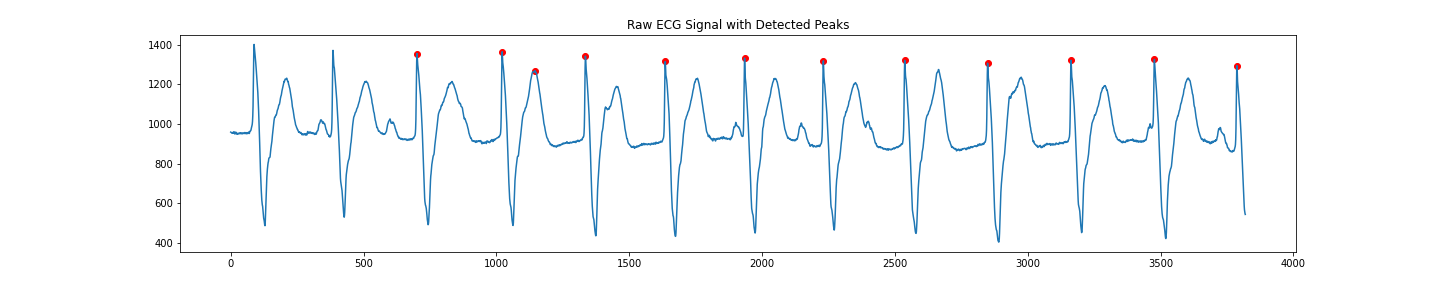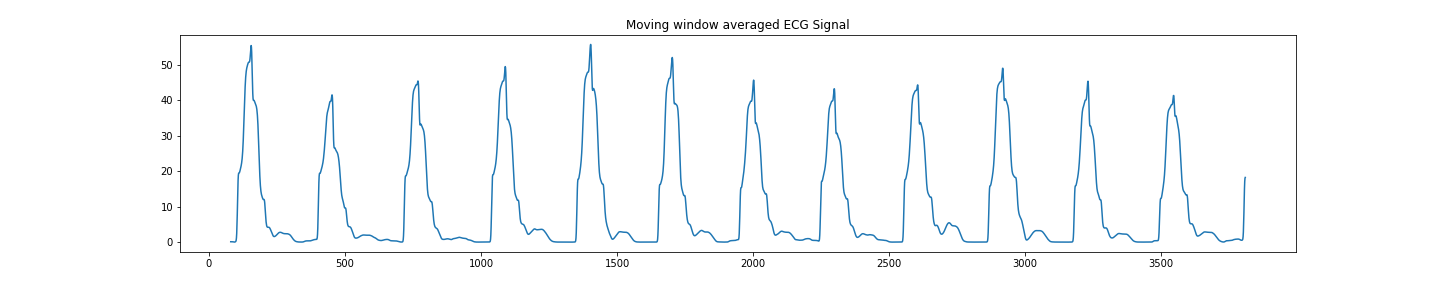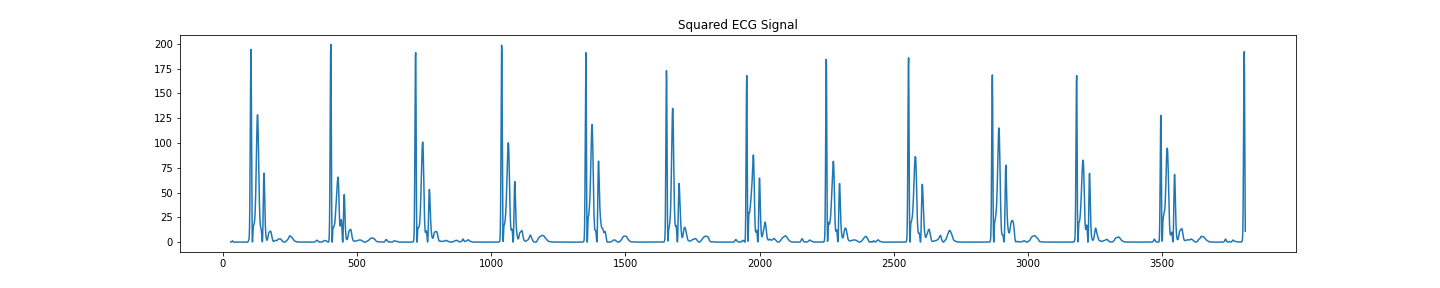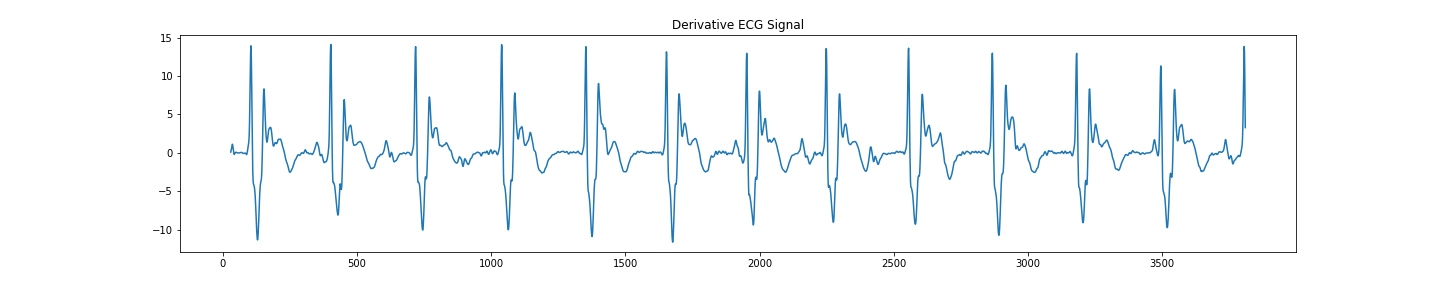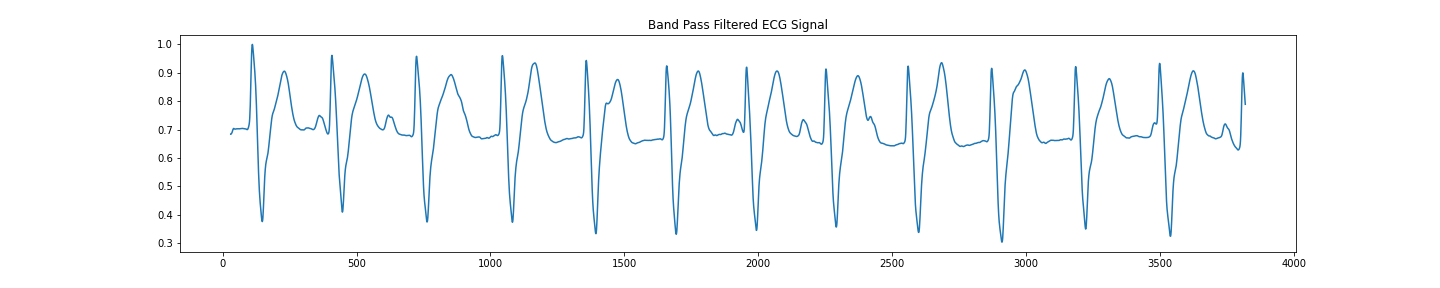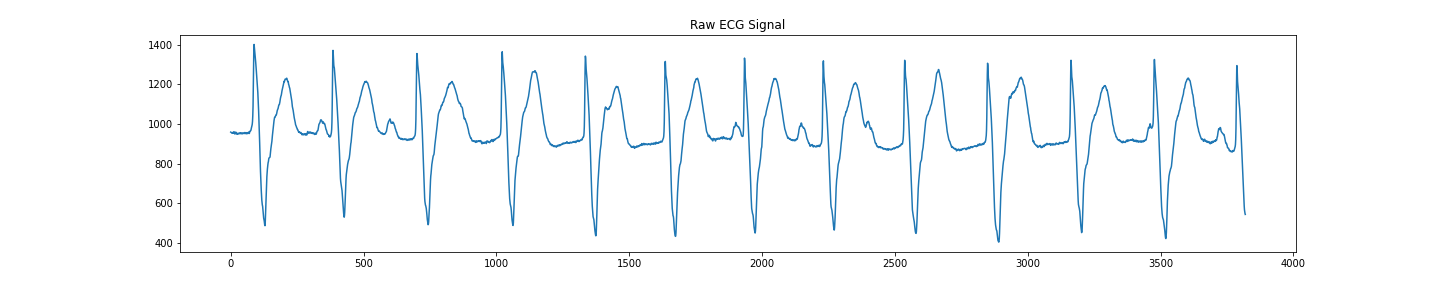

**Record 108**

Heart Rate: 131.792 BPM

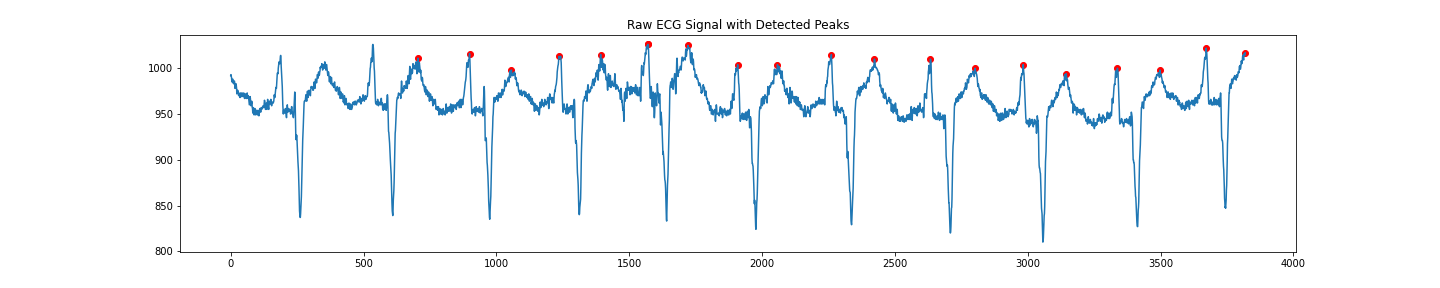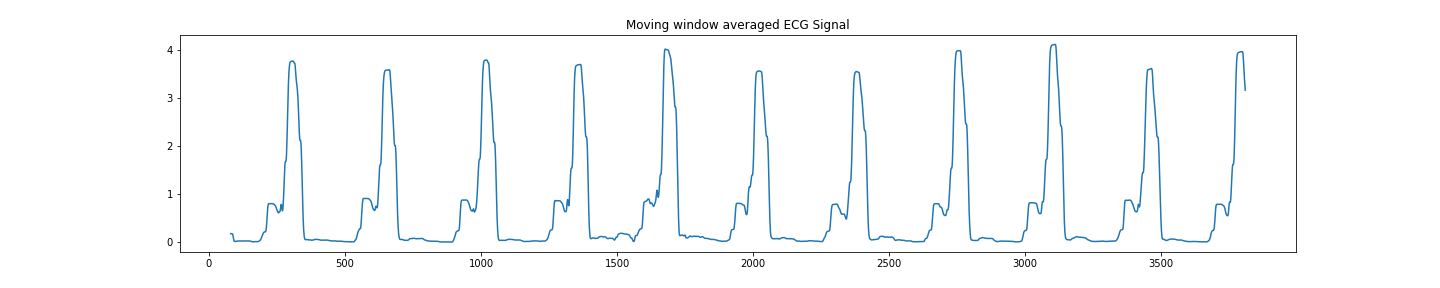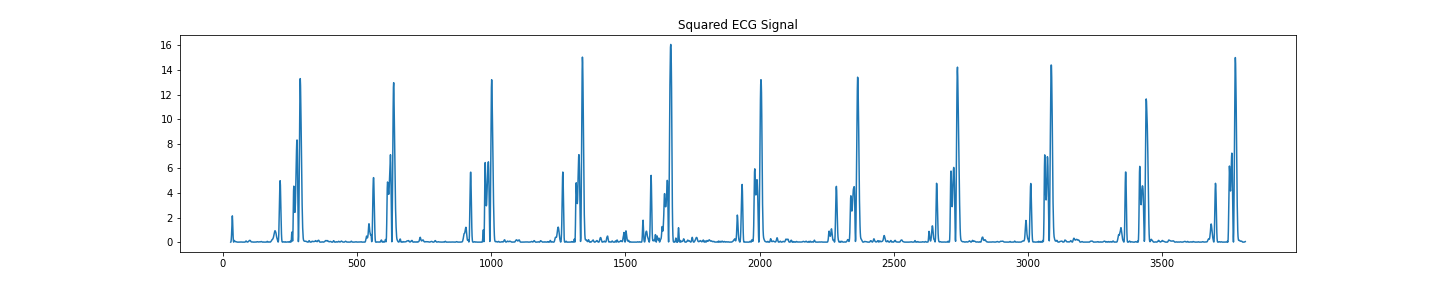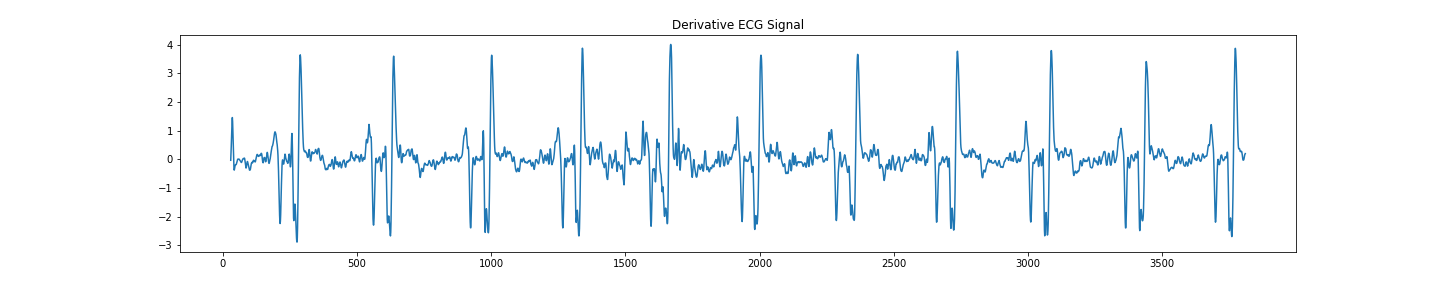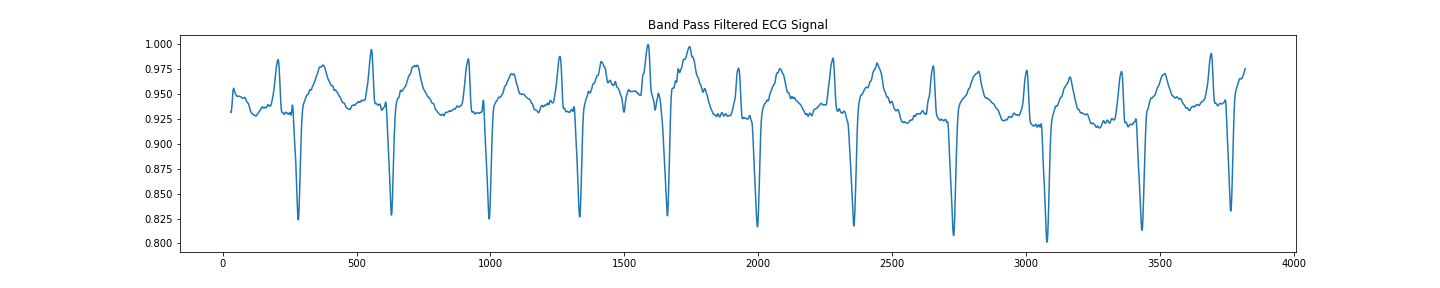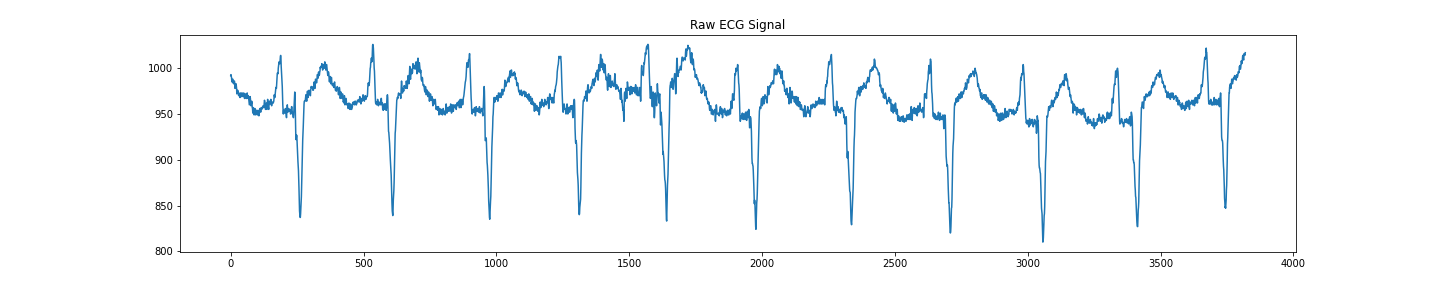

**Record 109**

Heart Rate: 109.327 BPM

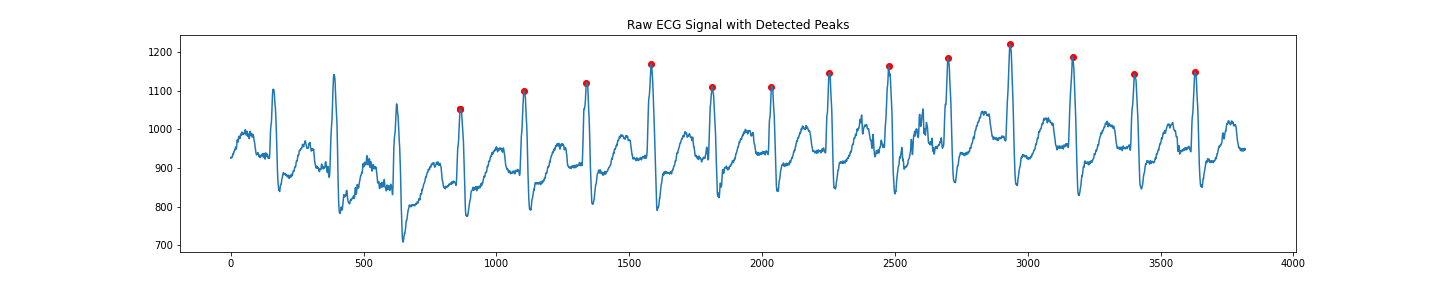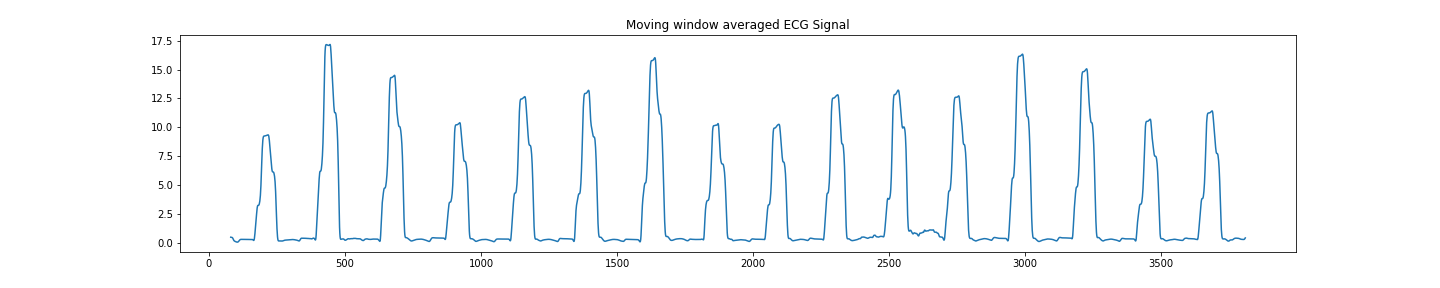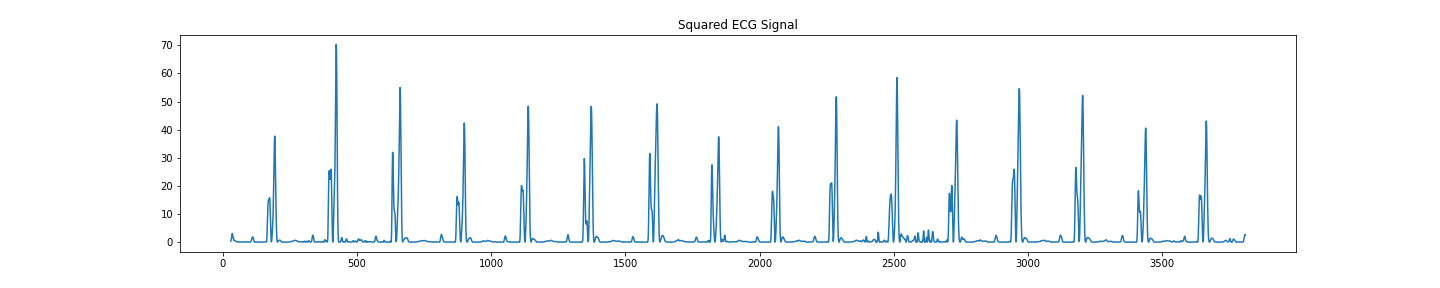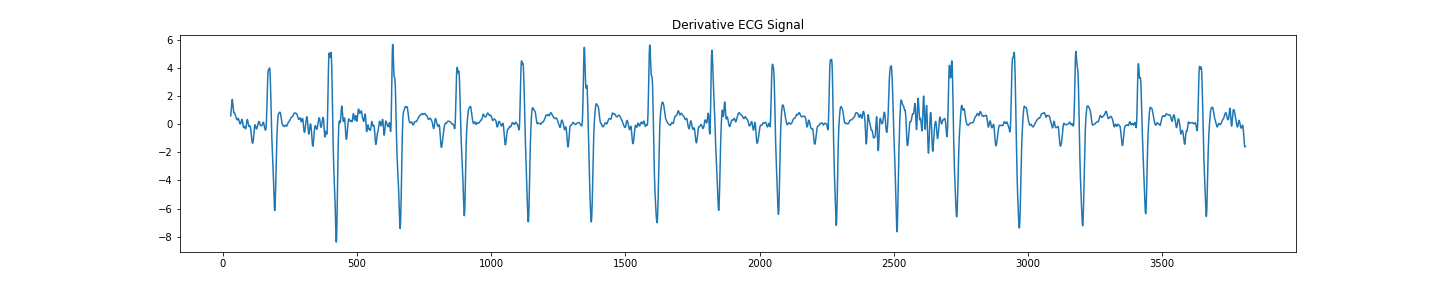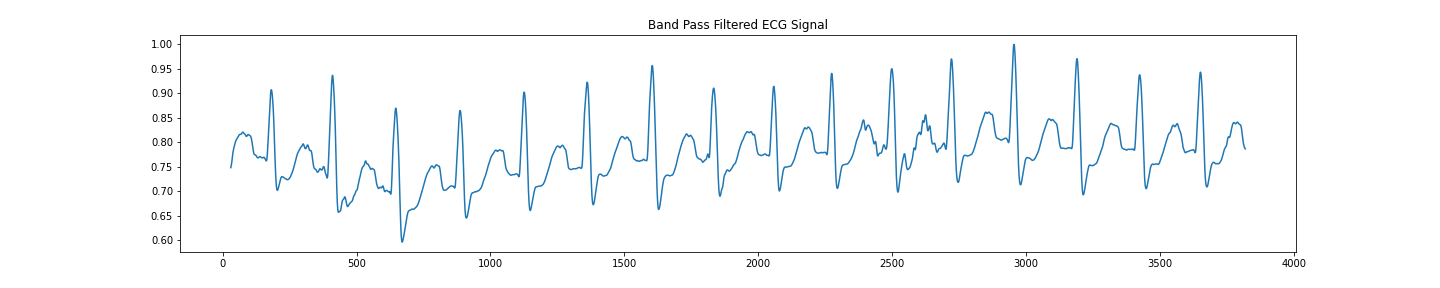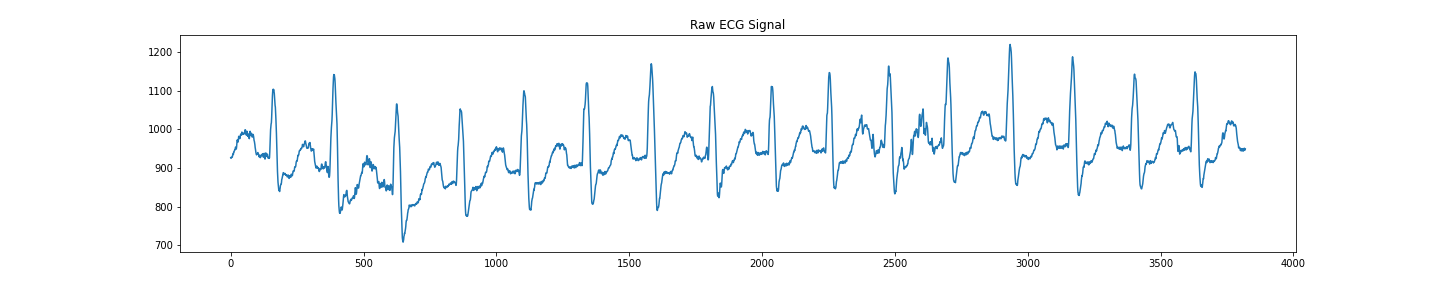




## Conclusion

To recognise QRS complexes in real-time, ambiance of noise and rapidly changing and varied ECG morphologies, the Pan-Tompkins algorithm employs filtering, adaptive thresholding, criterias based on human heart physiology etc. There are many applications to the algorithm. A lot of times it is used to calculate just the R-peaks instead of the whole QRS complex, and thus it has a lot of applications in Heart Rate Variability(HRV). Since the algorithm is a real-time algorithm, it also has applications in heart-rate calculations in reat time. 

Overall the algorithms does a good job in identifying peaks and QRS complexes apart from all the noise and other factors. 